In [4]:
import SimpleITK as sitk # https://simpleelastix.readthedocs.io/ for install instructions

import numpy as np
import pandas as pd
import scipy as sp
import scipy.interpolate
from scipy import ndimage
from scipy.spatial.transform import Rotation as R

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import skimage
import skimage.io
import skimage.transform
import skimage.exposure
import skimage.filters
import skimage.morphology

import tifffile
import nrrd

import math, re, os, shutil, ast, sys, time, random, gc, pickle, time, copy

import anndata

In [5]:
# definitions

# overlay to images to green and magenta
def imageoverlay(imG, imM):
    assert imG.shape == imM.shape
    output = np.zeros(imG.shape + (3,))
    g = skimage.util.img_as_float(imG)
    m = skimage.util.img_as_float(imM)
    output[:,:,0] = m 
    output[:,:,2] = m
    output[:,:,1] = g
    return output

# makes result image have values from 0-1 so it is acceptable to skimage
def scale_result(im):
    return (im - np.min(im))/np.ptp(im)

# adjust the contrast and brightness using percentage of cumulative distribution
def imagescPercent(im, percentlow, percenthigh):
    c , bins = skimage.exposure.cumulative_distribution(im)
    intlow = bins[np.argmin(np.abs(c - percentlow))].astype(im.dtype)
    inthigh = bins[np.argmin(np.abs(c - percenthigh))].astype(im.dtype)
    return skimage.exposure.rescale_intensity(im, in_range = (intlow, inthigh))

def border_transparency(im, RGBval = [1,1,1]):
    im = im/np.amax(im)
    alphas = im > np.amax(im)/5 # the input should have been a single values image anyways...
    rgb = im[:,:,None] * np.array(RGBval)
    return np.concatenate((rgb, alphas[:,:,None]), axis = 2)

# adjust the contrast and brightness using percentage of cumulative distribution
def adjustBC(im, percentlow, percenthigh):
    c , bins = skimage.exposure.cumulative_distribution(im)
    intlow = bins[np.argmin(np.abs(c - percentlow))].astype(im.dtype)
    inthigh = bins[np.argmin(np.abs(c - percenthigh))].astype(im.dtype)
    return skimage.exposure.rescale_intensity(im, in_range = (intlow, inthigh))

# rescale an image size and return uint16
# the preserve range thing here is weird, can it be set to true without the conversion?
def image_rescale(im, factor):
    return skimage.util.img_as_uint(skimage.transform.rescale(im, factor, preserve_range = False))

# fit a list of different sized images into one array
def image_list_to_array(ims):
    size_max = np.amax(np.array([im.shape for im in ims]), axis = 0)
    output = np.zeros([len(ims),size_max[0],size_max[1]], dtype = ims[0].dtype)
    for i,im in enumerate(ims):
        cols, rows = im.shape
        output[i,0:cols,0:rows] = im
    return output

# make some sort of funtion to pre process the data for registration

# gaussian blur
def blur(im, rad = 15):
    return skimage.filters.gaussian(im, rad)

def preprocess(im, thresh_factor = 1, rad = 15):
    edge = skimage.filters.sobel(im)
    thresh = skimage.filters.threshold_otsu(edge)
    return skimage.filters.gaussian(edge > thresh, rad)

def preprocess(im, thresh_factor = 1, rad = 5):
    edge = skimage.filters.sobel(im)
    thresh = skimage.filters.threshold_otsu(edge)
    sel = skimage.morphology.disk(rad)
    output =  blur(skimage.morphology.binary_closing(edge > (thresh * thresh_factor), sel))
    return np.clip(output,0,1)

# binarize an image after blurring and choosing a threshold
def binarize(im, blur_size = 1, thresh_factor = 0.1):
    blurred = blur(im, rad = blur_size) 
    thresh = thresh_factor * skimage.filters.threshold_otsu(blurred)
    return blurred > thresh

def plot_histogram(im, bins = 256, irange = (0,65535)):
    histogram, bin_edges = np.histogram(im, bins=bins, range=irange)
    plt.plot(bin_edges[0:-1], histogram)
    plt.ylim(0,np.amax(histogram[1:]))
    plt.show()

def find_corner(im, area_thresh = 100):
    imB = binarize(im)
    labels = skimage.measure.label(imB)
    rprops = skimage.measure.regionprops(labels)
    rprops = [p for p in rprops if p.area > area_thresh]
    rmin, cmin = np.amin(np.array([p.bbox for p in rprops]), axis = 0)[[0,1]]
    rmax, cmax = np.amax(np.array([p.bbox for p in rprops]), axis = 0)[[2,3]]
    return rmin, cmin, rmax, cmax

# crop an image using the find_corner function
def crop_image(im):
    bbox = find_corner(im)
    return im[bbox[0]:bbox[2], bbox[1]:bbox[3]]

# this will make a test grid the same size as the image
def make_grid_image(im, grid_size = 220, pix_size = 50):
    dxy = int(grid_size / pix_size)
    output = np.zeros(im.shape)
    for r in range(0, im.shape[0], dxy):
        output[r] = 1
    for c in range(0, im.shape[1], dxy):
        output[:,c] = 1
    return output

def make_grid_image_3D(im, grid_size = 220, pix_size = 50):
    dxy = int(grid_size / pix_size)
    output = np.zeros(im.shape)
    for s in range(0, im.shape[0], dxy):
        output[s] = 1
    for r in range(0, im.shape[1], dxy):
        output[:,r] = 1
    for c in range(0, im.shape[2], dxy):
        output[:,:,c] = 1
    return output

## funtions for transforming points sets

def mat_trans(dx, dy):
    return np.array([[1,0,dx],[0,1,dy],[0,0,1]])

def mat_scale(sx, sy):
    return np.array([[sx,0,0],[0,sy,0],[0,0,1]])

def mat_rot(deg): #2D rotation matrix
    theta = np.deg2rad(deg)
    return np.array([[np.cos(theta),-np.sin(theta),0],[np.sin(theta),np.cos(theta),0],[0,0,1]])

def mat_reflect(reflect = False, dx = 0):
    if reflect:
        return np.array([[-1,0,dx],[0,1,0],[0,0,1]])
    else:
        return np.array([[1,0,0],[0,1,0],[0,0,1]])
    
#adapted from skimage.transform.rotate to account for image size increase
def find_new_corner(rows, cols, deg):

    corners = np.array([
            [0, 0, 1],
            [0, rows - 1, 1],
            [cols - 1, rows - 1, 1],
            [cols - 1, 0, 1]
        ])
    
    # meant for odd numbers? regardless, this is the definition in skimage...
    center = [cols/2 - 0.5, rows/2 - 0.5]
    
    tform1 = mat_trans(-center[0], -center[1])
    tform2 = mat_rot(deg)
    tform3 = mat_trans(center[0], center[1])
    tform = tform3 @ tform2 @ tform1
    #print(corners) # these are the corners before transform
    corners = tform[None, :,:] @ corners[:,:,None]
    #print(corners) # these are the corners after transform
    minc = corners[:, 0].min()
    minr = corners[:, 1].min()
    maxc = corners[:, 0].max()
    maxr = corners[:, 1].max()
    
    out_rows = int(maxr - minr + 1)
    out_cols = int(maxc - minc + 1)
    
    # return the new corners and widths after rotation
    return [minr, minc, out_rows, out_cols]

def transform_positions(tform, array):
    vals = np.concatenate([array,np.ones((len(array),1))], axis = 1)
    out = tform[None,:,:] @ vals[:,:,None]
    return out[:,0:2,0]

# note change to index here
def write_pts_file(array, name = 'points.pts'):
    with open(name, 'w') as f:
        f.write('point\n')
        f.write(str(len(array)) + '\n')
        # write the values in x, y order
        for row in array:
            for r in row:
                f.write(str(r) + ' ')
            f.write('\n')
            
def read_outputpoints_file():
    # the order here is 
    # InputIndex InputPoint OutputIndexFixed OutputPoint Deformation OutputIndexMoving
    with open('outputpoints.txt', 'r') as f:
        lines = f.readlines()
    output = []
    for line in lines:
        columns = line.split('\t;')[1:]
        pairs = [list(map(float, col.split('=')[1].strip(' []\n').split( ))) for col in columns]
        output.append(pairs)
    return np.array(output)

# find the center of the raw image
def find_center(im):
    imdim = im.shape
    
    if imdim[0]%2 == 0:
        imcenterr = imdim[0]/2
    else:
        imcenterr = imdim[0]/2 - 0.5

    if imdim[1]%2 == 0:
        imcenterc = imdim[1]/2
    else:
        imcenterc = imdim[1]/2 - 0.5
    
    return np.array([imcenterr,imcenterc])
    
# define function for parsing image names
def parse_filename(filename, regex = None):
    if regex is None:
        regex = "(?P<sample>.*)_slice(?P<slice>\d)_y_(?P<y1>[-]*\d+)_(?P<y2>[-]*\d+)_x_(?P<x1>[-]*\d+)_(?P<x2>[-]*\d+)_(?P<remainder>.*)"
    pat = re.compile(regex)
    res = pat.match(filename)
    return [res['sample'],int(res['slice']),int(res['y1']),int(res['y2']),int(res['x1']),int(res['x2'])]

def crop_and_pad_image(image1, image2 = None, pad_width = 20, area_thresh = 20):
    bbox = find_corner(image1, area_thresh = area_thresh)
    image1 = np.pad(image1[bbox[0]:bbox[2],bbox[1]:bbox[3]], pad_width)
    if not image2 is None:
        image2 = np.pad(image2[bbox[0]:bbox[2],bbox[1]:bbox[3]], pad_width)
    return bbox, image1, image2

def crop_and_pad_points(pointsXY, bbox, pad_width = 20):
    output_pts = pointsXY - np.array(bbox[1], bbox[0]) # XY order for sitk
    output_pts = output_pts + pad_width
    return output_pts

def register_images(fixed_image, moving_image, params_rigid, params_spline = None, fixed_mask = None):
    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.SetParameterMap(params_rigid)
    if not params_spline is None:
        elastixImageFilter.AddParameterMap(params_spline)
        
    elastixImageFilter.SetFixedImage(sitk.GetImageFromArray(fixed_image))
    elastixImageFilter.SetMovingImage(sitk.GetImageFromArray(moving_image))
    
    if 'CorrespondingPointsEuclideanDistanceMetric' in [item for sublist in params_rigid.asdict().values() for item in sublist]:
        print('load corresponding points')
        elastixImageFilter.SetFixedPointSetFileName("fix.pts")
        elastixImageFilter.SetMovingPointSetFileName("mov.pts")
    
    # this is not working
    if not fixed_mask is None:
        mask = sitk.GetImageFromArray(fixed_mask)
        mask = sitk.Cast(mask, sitk.sitkUInt8)
        elastixImageFilter.SetFixedMask(mask)
        print('fixed mask set')
    
    elastixImageFilter.Execute()
    
    result_image = sitk.GetArrayFromImage(elastixImageFilter.GetResultImage())
    trans = elastixImageFilter.GetTransformParameterMap()
    
    return trans, result_image

def transform_image(moving_image, params, interpolation = True, spacing = None):
    transformixImageFilter = sitk.TransformixImageFilter()
    
    if not interpolation:
        if isinstance(params, tuple):
            for param in params:
                param["ResampleInterpolator"] = L2P(["FinalNearestNeighborInterpolator"])
        else:
            params["ResampleInterpolator"] = L2P(["FinalNearestNeighborInterpolator"])
    
    transformixImageFilter.SetTransformParameterMap(params)

    mov = sitk.GetImageFromArray(moving_image)

    if not spacing is None:
        mov.SetSpacing(spacing)
        print('SITK spacing set to {}'.format(mov.GetSpacing()))
    
    transformixImageFilter.SetMovingImage(mov)
    transformixImageFilter.Execute()
    result = sitk.GetArrayFromImage(transformixImageFilter.GetResultImage())
    return result

#convert a param to a numpy list to do manipulations on it
def P2L(param):
    return np.asarray([float(p) for p in param])

#convert a numpy list to a tuple with strings for the params
def L2P(paramlist):
    strs = [str(p) for p in paramlist]
    return tuple(strs)

def params_from_df(df, num):     
    # make some affine params
    p = sitk.GetDefaultParameterMap("affine")
    p['NumberOfResolutions'] = L2P([4])
    p['MaximumNumberOfIterations'] = L2P([500])
    #p['NumberOfSpatialSamples'] = L2P([4096])
    p['NumberOfHistogramBins'] = L2P([32]) 
    if not np.isnan(df.iloc[num].histogram_bins):
        p['NumberOfHistogramBins'] = L2P([df.iloc[num].histogram_bins])
    # make some spline params
    p2 = sitk.GetDefaultParameterMap("bspline")
    #p2['NumberOfSpatialSamples'] = L2P([32000])
    p2['NumberOfResolutions'] = L2P([4])
    p2['GridSpacingSchedule'] = L2P([20,10,5,2])
    p2['NumberOfHistogramBins'] = L2P([32]) 
    if not np.isnan(df.iloc[num].histogram_bins):
        p2['NumberOfHistogramBins'] = L2P([df.iloc[num].histogram_bins])
    p2['MaximumNumberOfIterations'] = L2P([500])
    if not np.isnan(df.iloc[num].iterations):
        p2['MaximumNumberOfIterations'] = L2P([df.iloc[num].iterations])
    p2['FinalGridSpacingInPhysicalUnits'] = L2P([]) # this remove the param?
    p2['FinalGridSpacingInVoxels'] = L2P([16])
    if not np.isnan(df.iloc[num].spline_grid_size):
        p2['FinalGridSpacingInVoxels'] = L2P([df.iloc[num].spline_grid_size])
        
    # check if there is a csv file with corresponding points...
    
    csv_file = os.path.splitext(df.iloc[num].Filename)[0] + '.csv'
    if os.path.exists(csv_file):
        print('corresponding points file found: {}'.format(csv_file))
        p['Registration'] = L2P(["MultiMetricMultiResolutionRegistration"])
        p['Metric'] = L2P(['AdvancedMattesMutualInformation','CorrespondingPointsEuclideanDistanceMetric'])
        p['Metric0Weight'] = L2P([1 - df.iloc[num].cor_pts_weight])
        p['Metric1Weight'] = L2P([df.iloc[num].cor_pts_weight])
        
        p2['Registration'] = L2P(["MultiMetricMultiResolutionRegistration"])
        p2['Metric'] = L2P(['AdvancedMattesMutualInformation','CorrespondingPointsEuclideanDistanceMetric'])
        p2['Metric0Weight'] = L2P([1 - df.iloc[num].cor_pts_weight])
        p2['Metric1Weight'] = L2P([df.iloc[num].cor_pts_weight])
    
    return p, p2

# importing images from a dataframe
# read the image with some info from a dataframe
def image_from_df(df, index, right_crop = True, scale = True):
    im = skimage.io.imread(df.iloc[index]['Filename'])
    if not np.isnan(df.iloc[index]['rot_init']):
        im = skimage.transform.rotate(im, df.iloc[index]['rot_init'], resize = True)
    if df.iloc[index]['reflect']:
        im = np.flip(im, axis = 1)
    if right_crop:
        if not np.isnan(df.iloc[index]['right_crop']):
            im[:,int(df.iloc[index]['right_crop']):] = 0
    if scale:
        if not (np.isnan(df.iloc[index]['scale_x']) and np.isnan(df.iloc[index]['scale_y'])):
            new_size = im.shape * np.array([df.iloc[index]['scale_y'],df.iloc[index]['scale_x']])
            new_size = new_size.astype(int)
            im = skimage.transform.resize(im, new_size)
    return im

# make a function that can re-import the dataframe and interpolate the desired columns
def import_df(path):
    df = pd.read_excel(path)
    df = df.sort_values('z_pos', ignore_index = True)
    
    columns = ['allen_slice_num', 'angle_ZY', 'angle_ZX']    # columns to interpolate
    for col in columns:
        x = df.z_pos.values[np.logical_not(np.isnan(df[col].values))]
        y = df[col].values[np.logical_not(np.isnan(df[col].values))]
        f = scipy.interpolate.interp1d(x, y, kind='linear', fill_value = 'extrapolate')
        df[col] = f(df.z_pos)
    
    df['allen_slice_num'] = df['allen_slice_num'].values.astype(int)
    #
    df['space_modules'] = df['space_modules'].apply(lambda x: ast.literal_eval(str(x)))
    df['cell_types'] = df['cell_types'].apply(lambda x: ast.literal_eval(str(x)))
    df['annots_to_amplify'] = df['annots_to_amplify'].apply(lambda x: ast.literal_eval(str(x)))
    return df

# use the image info dataframe to get some cell metadata from the cell metadata dataframe
def get_cell_metadata_for_slice_index(df, index, cmd, ccf_pixel_size = 25, bbox = None, pad_width = 20):
    file = df.iloc[index].Filename
    rot = df.iloc[index].rot_init
    reflect = df.iloc[index].reflect
    scale_x, scale_y = [df.iloc[index].scale_x, df.iloc[index].scale_y]
    dataname, slicenum, y1, y2, x1, x2 = parse_filename(file)
    # need to know some stuff about the raw image
    imraw = skimage.io.imread(file)
    imdim = np.array(imraw.shape)
    imcenter = find_center(imraw)
    umperpixY = (y2-y1)/imdim[0]
    umperpixX = (x2-x1)/imdim[1]
    # here is the cell metadata subset
    cmd_temp = cmd[cmd.sample_id == df.iloc[index].cell_metadata]
    tform1 = mat_trans(-x1,-y1) # move the corner of the image to the origin
    tform2 = mat_scale(1/umperpixX, 1/umperpixY) # scale the image into pixels
    tform3 = mat_trans(imcenter[1],imcenter[0]) @ mat_rot(-rot) @ mat_trans(-imcenter[1],-imcenter[0]) # do initial rotation (translated to the center, rotate, translate back)
    shiftr, shiftc, out_rows, out_cols = find_new_corner(imdim[0], imdim[1], -rot) # find the new size of the image since it was rotated
    tform4 = mat_trans(-shiftc,-shiftr) # shift to the new corner
    tform5 = mat_reflect(reflect = reflect, dx = out_cols) # reflect if there is a reflection
    tform6 = mat_scale(scale_x,scale_y) # do final scaling in x and y which was added for better registration
    if bbox is None:
        tform =  tform6 @ tform5 @ tform4 @ tform3 @ tform2 @ tform1 # final transform of everything!
    else:
        tform7 = mat_trans(-bbox[1],-bbox[0]) # crop in on the cells
        tform8 = mat_trans(pad_width,pad_width) # add padding
        tform =  tform8 @ tform7 @ tform6 @ tform5 @ tform4 @ tform3 @ tform2 @ tform1 # final transform of everything!
    
    cells =  cmd_temp[(y1 < cmd_temp['center_y']) &
                      (cmd_temp['center_y'] < y2) & 
                      (x1 < cmd_temp['center_x']) & 
                      (cmd_temp['center_x'] < x2)].copy() # make a copy so it does not give the slice warning...
    
    cells_pos = np.array([cells['center_x'], cells['center_y']]).T
    cells_pos_image_space = transform_positions(tform, cells_pos) # transform the cell positions from the initial transforms
    cells['fixed_x'] = cells_pos_image_space[:,0]
    cells['fixed_y'] = cells_pos_image_space[:,1]
    return cells

# interactive point picking
def onpick(event):
    # mouse position in the image
    xmouse = event.mouseevent.xdata
    ymouse = event.mouseevent.ydata
    
    points_cor_x.append(xmouse)
    points_cor_y.append(ymouse)
    
    if len(points_cor_x)%2!=0:
        axs[0].scatter(xmouse, ymouse , marker = 'x', color = 'y', s = 100, linewidth = 3)
        axs[0].annotate(str(math.ceil(len(points_cor_x)/2)), 
                        xy = [xmouse, ymouse], color = 'y', fontsize = 12)
    else:
        axs[1].scatter(xmouse, ymouse , marker = 'x', color = 'y', s = 100, linewidth = 3)
        axs[1].annotate(str(math.ceil(len(points_cor_x)/2)), 
                xy = [xmouse, ymouse], color = 'y', fontsize = 12)

    plt.draw()

In [6]:
# make sure sitk is working
elastixImageFilter = sitk.ElastixImageFilter()

In [4]:
%matplotlib inline
#%matplotlib qt

In [ ]:
# links for ara files
# annotation 
# http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/
# nissl
# http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/ara_nissl/
# dated last modified 2015-04-15

In [30]:
# files

# this excel sheet stores info about the dapi slice images and registration parameters
slice_info_filename = 'WB3_Coronal_2_mosaic_positions_25um_final.xlsx'
# this excel sheet store correspondence between cell types and annotated regions
structure_df_file = 'WB3_co2_cell_types_to_annotations.xlsx'

base_path = os.path.split(os.getcwd())[0]

# subclass color csv file
subclass_color_csv_file = os.path.join(base_path, 'subclass_colors_new.csv')
# allen lut csv file
allen_lut_file = os.path.join(base_path, 'allen lut.csv')
# dictionary mapping allen name to annotation
name_to_annotation_file = os.path.join(base_path, 'allen_name_to_annots.pkl')

# allen nissl and annotation file
ara_nissl_file = os.path.join(base_path, 'ara_nissl_25.nrrd')
ara_annot_file = os.path.join(base_path, 'annotation_25.nrrd')
ara_annot_10_file = os.path.join(base_path, 'annotation_10.nrrd')

# allen border file
# see "allen annotation to border.ipynb"
allen_border_file = os.path.join(base_path, 'annotations_25_border_only.tif')

# cell metadata file
# key columns are center_x, center_y, slice_id, subclass_label_transfer, spatial_modules_level_1
cmd_file = os.path.join(base_path, 'wb3_cell_metadata_cp2_integration_sm1.csv')

In [ ]:
# important note
# when saving annotation as tif, we have observed that the integer values can be incorrectly saved
# thus make sure to read directly from the nrrd file https://pynrrd.readthedocs.io/en/stable/

# importing images

In [6]:
# import the excel sheet that has the slice positions, rotations and reflections
# sort depending on the Z value
df = pd.read_excel(slice_info_filename)
df = df.sort_values('z_pos', ignore_index = True)
len(df)

150

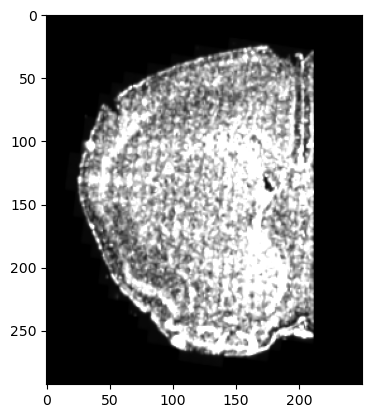

In [7]:
#%matplotlib inline
num = 50
plt.imshow(adjustBC(image_from_df(df,num),0,0.9), cmap = 'gray')

### Colormaps

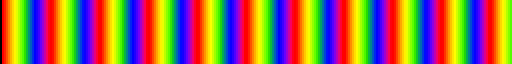

In [8]:
# rainbow colormap
# take the prism colormap and make the zero value black
# turn it into a listed colormap
cmap = cm.prism(np.arange(256))
cmap[0] = [0,0,0,1]
cmap = ListedColormap(cmap)
# set maximum colors to display
max_colors = 1140

cmap

In [9]:
# make an LUT with lots of values
def RGB_lut_255(unique_values):
    cmap = (255 * cm.gist_rainbow(np.arange(256))).astype(np.uint8)
    cmap[0] = [0,0,0,1]
    return cmap[np.linspace(0,255,unique_values).astype(int)][:,0:3]

In [14]:
# Allen colormap

df_lut = pd.read_csv(allen_lut_file, names = ['Annotation','R','G','B'])

# make a blank look up table
# this is actually a numpy list
lut = np.zeros([np.amax(df_lut.Annotation) + 1,3], dtype = np.uint8) # add 1 to max value...
# lut needs to be uint8 for RGB
lut.shape

# set the values from the lut
for i,row in df_lut.iterrows():
    lut[row.Annotation] = [row.R,row.G,row.B]

In [15]:
# new subclass colors
temp_df = pd.read_csv(subclass_color_csv_file)
subclass_color = {}
for i, row in temp_df.iterrows():
    subclass_color[row.subclass] = row.color
    
subclass_color['LQ'] = '#ffffff'

# use old DG Glut color
subclass_color['DG Glut'] = '#2bb179'

# Import allen data

In [16]:
#have all of the allen name to annotations at hand
with open(name_to_annotation_file, 'rb') as handle:
    allen_name_to_annots = pickle.load(handle)

len(allen_name_to_annots)

1327

In [18]:
# import nissl

ccf_pixel_size = 25

midline = 228
extra = 8

nissl, header = nrrd.read(ara_nissl_file, index_order='F')
nissl = nissl[:,:,:midline + extra]
print(nissl.shape)

# import annotations
annot, header = nrrd.read(ara_annot_file, index_order='F')
annot = annot[:,:,0:midline + extra]
print(annot.shape)

(528, 320, 236)
(528, 320, 236)


In [14]:
# having some trouble interpolating the annotated image with high values
# hopefully this can shift the values to unused lower values and then shift back the original values
annot_unique = np.unique(annot)

annot_convert = np.zeros(annot_unique[-1] + 1, dtype=np.uint32)
for i,val in enumerate(annot_unique):
    annot_convert[val] = i

annot_revert = np.zeros(len(annot_unique), dtype=np.uint32)
for i,val in enumerate(annot_unique):
    annot_revert[i] = val

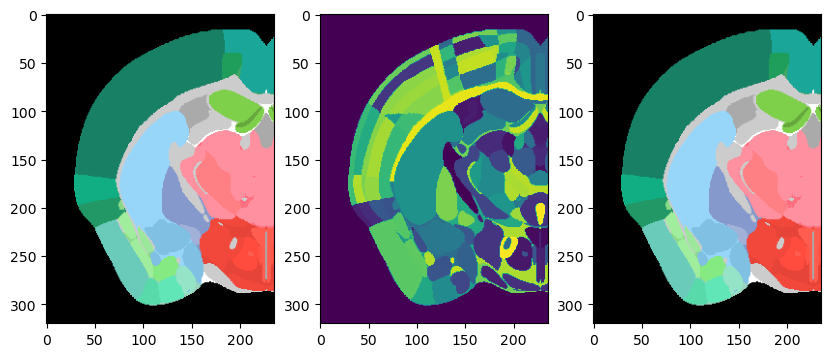

In [15]:
# here is an example
slice_num = 250
fig, axs = plt.subplots(1,3, figsize = (10,5))
axs[0].imshow(lut[annot[slice_num]])
axs[1].imshow(annot_convert[annot[slice_num]])
axs[2].imshow(lut[annot_revert[annot_convert[annot[slice_num]]]])

In [20]:
# import border image
# see "allen annotation to border.ipynb" notebook for how to generate these
# useful for displaying purposes

borders = skimage.io.imread(allen_border_file)
borders = borders[:,:,:midline + extra]
print(borders.shape)
print(borders.dtype)

(528, 320, 236)
uint8


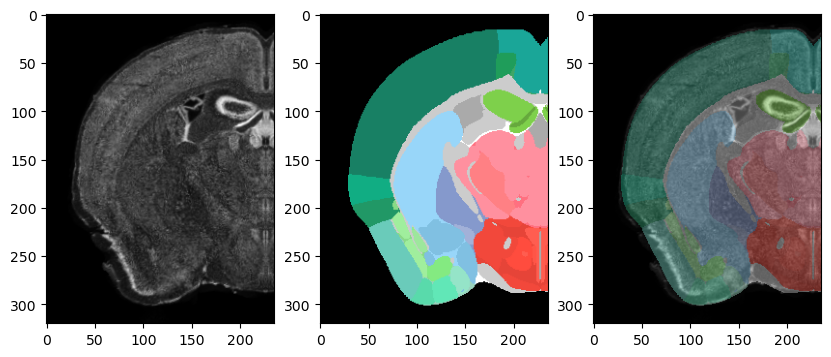

In [17]:
slice_num = 250
fig, axs = plt.subplots(1,3, figsize = (10,5))
axs[0].imshow(nissl[slice_num], cmap = 'gray')
axs[1].imshow(lut[annot[slice_num]])
axs[2].imshow(nissl[slice_num], cmap = 'gray')
axs[2].imshow(lut[annot[slice_num]], alpha = 0.4)

# interpolate allen slices from cut positions

[   0.9192517  -464.18542284]


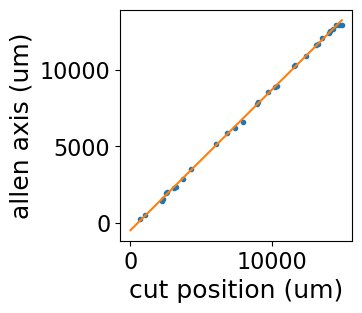

In [18]:
df = pd.read_excel(slice_info_filename)

# sometimes there will be nan values here if we don't fill in this column completely
# can interpolate the values
df.allen_slice_num.values

#####

x = df.z_pos.values[np.logical_not(np.isnan(df.allen_slice_num.values))]

x_slice = df.Slice.values[np.logical_not(np.isnan(df.allen_slice_num.values))]
y = df.allen_slice_num.values[np.logical_not(np.isnan(df.allen_slice_num.values))]

####

um_per_slice_allen = 25

fit = np.polyfit(x, um_per_slice_allen * y, 1)
x_fit = np.arange(np.amax(x))
y_fit = x_fit * fit[0] + fit[1]

print(fit)

fig, axs = plt.subplots(1,1, figsize = (3,3))
fs = 18
axs.plot(x, y * um_per_slice_allen, '.')
axs.plot(x_fit,y_fit)
axs.set_ylabel('allen axis (um)', fontsize=fs)
axs.set_xlabel('cut position (um)', fontsize=fs)
axs.tick_params(axis='both', which='major', labelsize=16)

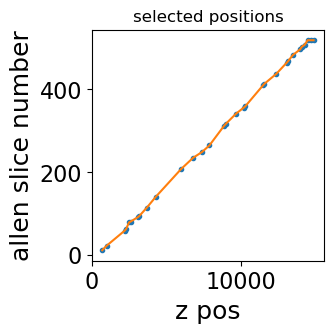

In [19]:
f = scipy.interpolate.interp1d(x, y, kind='linear', fill_value = 'extrapolate')

allen_slice_orig = np.copy(y)
# rewrite the allen slice number with the interpolated version
df.allen_slice_num = f(df.z_pos).astype(int)

fig, axs = plt.subplots(1,1,figsize=(3,3))

axs.set_title('selected positions')
axs.plot(x,allen_slice_orig,'.')
axs.plot(x, f(x))
axs.set_ylabel('allen slice number',fontsize=fs)
axs.set_xlabel('z pos',fontsize=fs)
axs.tick_params(axis='both', which='major', labelsize=16)

In [20]:
# test df importing
df = import_df(slice_info_filename)

# cell metadatas

In [22]:
cmd = pd.read_csv(cmd_file, index_col = 0)
print(len(cmd))
# only take co2 samples
co2_samples = cmd.sample_id.str.contains('co2_')
cmd = cmd[co2_samples]
cmd.index.rename('cell_id', inplace = True)
print(len(cmd))

10025673
5176286


In [24]:
cmd.columns

Index(['fov', 'volume', 'center_x', 'center_y', 'sample_id', 'slice_id',
       'fov_x', 'fov_y', 'integration_partition_transfer',
       'integration_partition_confidence', 'subclass_label_transfer',
       'subclass_label_confidence', 'cl_transfer', 'cl_confidence',
       'cluster_cosine_similarity', 'adjusted_subclass_label_confidence',
       'adjusted_cl_confidence', 'spatial_modules_level_1', 'sm1_color',
       'local_color', 'spatial_modules_level_1_name', 'sm1n_color'],
      dtype='object')

In [23]:
cmd['lvl2_colors'] = cmd.subclass_label_transfer.map(subclass_color)
# handle no subclass
cmd.loc[cmd.subclass_label_transfer.isna(), 'lvl2_colors'] = subclass_color['LQ']                                            

In [24]:
for sm in cmd.spatial_modules_level_1_name.unique():
    print(sm)

SM_CTX
nan
SM_FT
SM_RSP
SM_OLF/HPF
SM_TH
SM_VS
SM_HB
SM_HY
SM_MB
SM_RT
SM_PAL/STR
SM_STR
SM_CB/FT
SM_CB
SM_MOB outer
SM_MOB inner


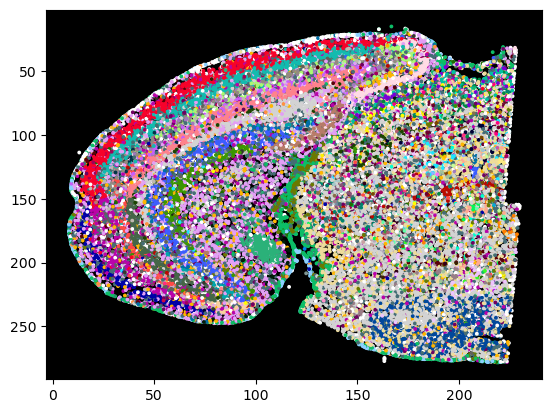

In [25]:
num = 102
cells = get_cell_metadata_for_slice_index(df, num, cmd, ccf_pixel_size = 25)

plt.figure()
#fixed = imagescPercent(image_from_df(df, num), 0, rescale_percent)
#plt.imshow(fixed, cmap = 'gray')
plt.gca().set_facecolor((0,0,0))
plt.scatter(cells['fixed_x'], cells['fixed_y'], s = 3, c = cells['lvl2_colors'])
plt.gca().invert_yaxis()

In [26]:
# lets make a place to store the raw cell metatdata
cmd_orig = cmd.copy()
len(cmd)

5176286

# modify nissl

In [28]:
# enhance certain regions of nissl image

annots_to_amplify = [507, 698, 665, 538, 900, 632]
annots_to_amplify = annots_to_amplify + allen_name_to_annots['Isocortex']

def modify_nissl(nissl, annot, factor = 10, annot_dict = None, midline = 228):
    output = np.copy(nissl)
    mean_val = np.mean(output[output > 0])
    annot = np.rint(annot).astype(np.int32)
    

    # vlmc layer
    mask = annot > 0
    output = output * mask # clear outside the annotation
    
    surface = np.logical_xor(mask, skimage.morphology.binary_dilation(mask, skimage.morphology.disk(2)))
    output[surface] = mean_val * factor # add vlmc
    
    # vlmc layer at isocortex/olf
    mask = np.isin(annot, allen_name_to_annots['Isocortex'])
    surface = np.logical_xor(mask, skimage.morphology.binary_dilation(mask, skimage.morphology.disk(2)))    
    output[surface] = mean_val * factor # add vlmc
    
    
    # vlcm at midline
    mask_ctx = np.isin(annot, allen_name_to_annots['Cerebral cortex'] + allen_name_to_annots['olfactory nerve layer of main olfactory bulb'])
    mask_midline = np.zeros(annot.shape, dtype = bool)
    mask_midline[:,midline-1:midline + 2] = True
    mask_midline = np.logical_and(mask_ctx, mask_midline)
    output[mask_midline] = mean_val * factor

    
    # Ependymal NN
    #annots_ENN = [73, 81, 89, 98, 108, 116, 124, 129, 140, 145, 153, 164]
    annots_ENN = [81,129]
    ventrical_mask = np.isin(annot, annots_ENN)
    edge_mask = np.logical_xor(ventrical_mask, skimage.morphology.binary_erosion(ventrical_mask, skimage.morphology.disk(2)))
    
    output[ventrical_mask] = 0 # remove ventricals
    output[edge_mask] = mean_val * factor # add surface
    
    
    if not annot_dict is None:
        for val in annot_dict:
            mask = (annot == val)
            output += mask * mean_val * factor
            
    return output

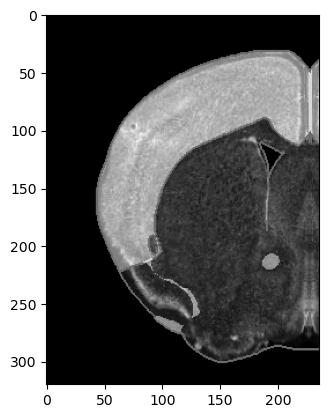

In [29]:
allen_slice_num = 200

output = modify_nissl(
                nissl[allen_slice_num],
                annot[allen_slice_num],
                annot_dict = annots_to_amplify,
                factor = 2)

fig, axs = plt.subplots(1,1)
axs.imshow(output, cmap = 'gray')

# modify dapi

In [31]:
# enhance certain regions of the dapi image using cell type information

cell_types_to_amplify = ['VLMC NN', 'Ependymal NN', 'CHOR NN', 'Tanyctye NN']
cell_types_to_amplify = cell_types_to_amplify + ['ABC NN', 'Astroependymal NN'] + ['DG Glut']

mob_cells = [
'MOB Dopa-Gaba',
'MOB Eomes Ms4a15 Glut',
'MOB Meis2 Gaba',
'MOB Trdn Gaba',
'MOB-STR-CTX Inh IMN',
'MOB-in Frmd7 Gaba',
'MOB-mi Frmd7 Gaba',
'MOB-out Frmd7 Gaba',
'IT AON-TT-DP Glut']

cell_types_to_amplify = cell_types_to_amplify + mob_cells

def modify_dapi(df, num, cmd, cell_types = None, space_modules = None, ccf_pixel_size = 25, factor = 10):
    dapi = image_from_df(df, num)
    cells = get_cell_metadata_for_slice_index(df, num, cmd, ccf_pixel_size = ccf_pixel_size)
    
    mean_val = np.mean(dapi[dapi > 0])
    
    ymax,xmax = dapi.shape
    mask = np.zeros(dapi.shape)
    
    cells = get_cell_metadata_for_slice_index(df, num, cmd, ccf_pixel_size = ccf_pixel_size)
    x = np.round(cells.fixed_x).astype(int)
    y = np.round(cells.fixed_y).astype(int)
    
    cond = ((x > 0) & (x < (xmax -1)) &
            (y > 0) & (y < (ymax -1)))
    cells = cells[cond]
    
    # enhance cell types
    if not cell_types is None:
        mask2 = np.zeros(dapi.shape)
        df_temp = cells[cells.subclass_label_transfer.isin(cell_types)]
        x = np.round(df_temp.fixed_x).astype(int)
        y = np.round(df_temp.fixed_y).astype(int)
        mask2[y,x] = mean_val * factor
        mask2 = skimage.filters.gaussian(mask2, sigma = 1)
        dapi += mask2
        
    # enhance space modules
    if not space_modules is None:
        mask2 = np.zeros(dapi.shape)
        df_temp = cells[cells.spatial_modules_level_1_name.isin(space_modules)]
        x = np.round(df_temp.fixed_x).astype(int)
        y = np.round(df_temp.fixed_y).astype(int)
        mask2[y,x] = mean_val * factor
        mask2 = skimage.filters.gaussian(mask2, sigma = 1)
        dapi += mask2
    
    #mask = skimage.morphology.binary_dilation(mask, skimage.morphology.disk(1))
    #dapi += mask * mean_val * factor 
    
    # remove any modifications after 'right crop'
    if not np.isnan(df.iloc[num]['right_crop']):
        rc = df.iloc[num]['right_crop']
        sx = df.iloc[num]['scale_x']
        rc_new = int(np.round(rc * sx))
        dapi[:,rc_new:] = 0
    
    return dapi

91


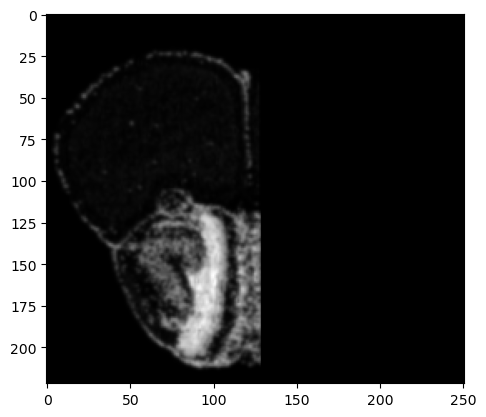

In [33]:
slice_num = 31
num = slice_num -1

df = import_df(slice_info_filename)
print(df.iloc[num].allen_slice_num)

dapi_mod = modify_dapi(df, num, cmd,
                             cell_types = cell_types_to_amplify,
                             factor = 10)
fig, axs = plt.subplots(1,1)
axs.imshow(dapi_mod, cmap = 'gray', vmin = 0)

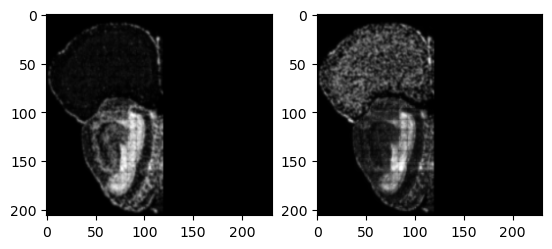

In [34]:
num = 28
dapi_ct = modify_dapi(df, num, cmd,
                             cell_types = cell_types_to_amplify,
                             factor = 5)

dapi_sm = modify_dapi(df, num, cmd,
                             space_modules = ['SM_CTX'],
                             factor = 5)


fig, axs = plt.subplots(1,2)
axs[0].imshow(dapi_ct, cmap = 'gray', vmin = 0)
axs[1].imshow(dapi_sm, cmap = 'gray', vmin = 0)

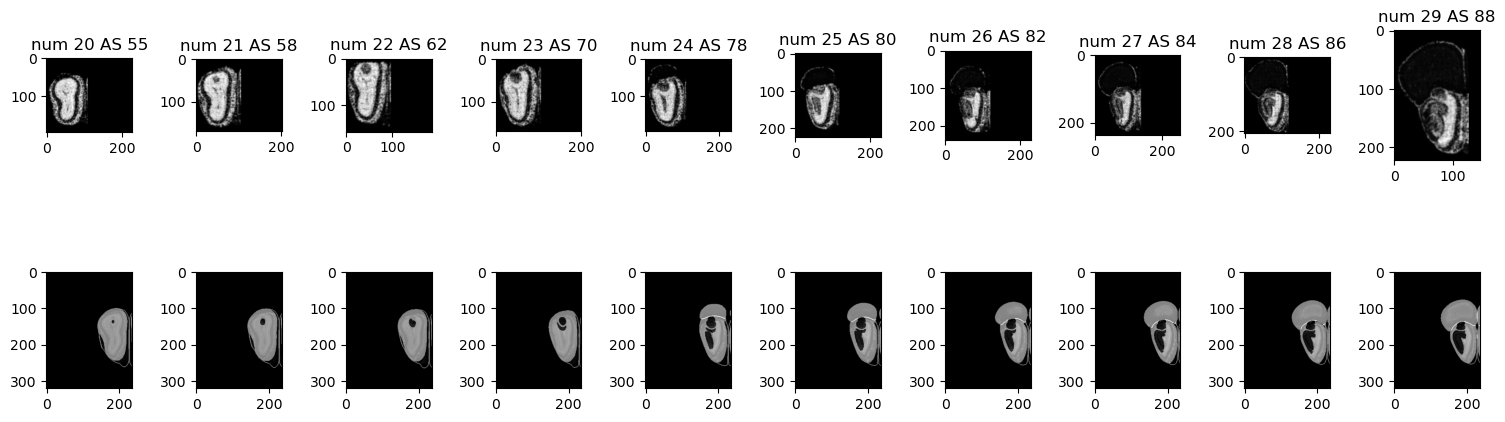

In [35]:
# make some side by side plots

num_start = 20
df = import_df(slice_info_filename)

ncols = 10
fig, axs = plt.subplots(2, ncols, figsize = (15,5))

for i in range(ncols):
    num = num_start + i
    nissl_im = nissl[df.iloc[num].allen_slice_num]
    annot_im = annot[df.iloc[num].allen_slice_num]
    
    nissl_1 = modify_nissl(nissl_im, annot_im, annot_dict = annots_to_amplify)
    dapi_1 = modify_dapi(df, num, cmd, cell_types_to_amplify)
    
    axs[0,i].set_title('num {} AS {}'.format(num, df.iloc[num].allen_slice_num))
    axs[0,i].imshow(dapi_1, cmap = 'gray')
    axs[1,i].imshow(nissl_1, cmap = 'gray')
plt.tight_layout()

# 2D Registration

In [36]:
%matplotlib qt

In [37]:
# test the registration of a slice
# parameters for registration are stored in the slice_info_filename
# an interactive popup window will appear
# alternately click on left image then right image to record corresponding points
# run the following cell to save a csv file
# the code will automatically find a csv file if it is present

In [72]:
slice_to_register = 45
print('slice to register {}'.format(slice_to_register))

num = slice_to_register - 1

df = import_df(slice_info_filename)
ccf_pixel_size = 25

filename = df.iloc[num].Filename
allen_slice_num = df.iloc[num].allen_slice_num

rescale_percent = 0.99

moving_annot = annot[allen_slice_num]
moving_borders = borders[allen_slice_num]
nissl_im = nissl[allen_slice_num]

print('nissl factor {}'.format(df.iloc[num].nissl_enhance_factor))
print('dapi factor {}'.format(df.iloc[num].dapi_enhance_factor))

fixed = modify_dapi(df, num, cmd,
    cell_types = df.iloc[num].cell_types,
    space_modules = df.iloc[num].space_modules,
    factor = df.iloc[num].dapi_enhance_factor)

moving  = modify_nissl(nissl_im, moving_annot,
    annot_dict = df.iloc[num].annots_to_amplify,
    factor = df.iloc[num].nissl_enhance_factor)

pad_width = 20

# crop images (may not be necessary since we did it already) and add a pad
fix_bbox, fixed, _ = crop_and_pad_image(fixed, pad_width = pad_width, area_thresh = 300)
_, _, moving_borders = crop_and_pad_image(moving, moving_borders, pad_width = pad_width, area_thresh = 300) # be careful here don't overwrite the original moving...
mov_bbox, moving, moving_annot = crop_and_pad_image(moving, moving_annot, pad_width = pad_width, area_thresh = 300) 

cells = get_cell_metadata_for_slice_index(df, num, cmd, ccf_pixel_size = ccf_pixel_size, bbox = fix_bbox, pad_width = pad_width)

fig, axs = plt.subplots(1,2)
axs[0].imshow(fixed, cmap = 'gray', picker=True)
axs[0].set_facecolor((0,0,0))
axs[0].scatter(cells['fixed_x'], cells['fixed_y'], s = 0.3, c = cells.lvl2_colors)

#axs[1].imshow(lut[moving_annot],  picker=True)
axs[1].imshow(moving,  picker=True)
axs[1].imshow(moving_borders, alpha = 0.5, cmap = 'gray')

fig.suptitle(filename)

points_cor_x = []
points_cor_y = []

fig.canvas.mpl_connect('pick_event', onpick)

slice to register 98
nissl factor 2
dapi factor 5


14

In [46]:
# if this cell is run, the points will be saved (or overwritten)
filename_csv = os.path.splitext(filename)[0] + '.csv'

df_points = pd.DataFrame()
df_points['fix_x'] = np.array(points_cor_x)[::2]
df_points['fix_y'] = np.array(points_cor_y)[::2]
df_points['mov_x'] = np.array(points_cor_x)[1::2]
df_points['mov_y'] = np.array(points_cor_y)[1::2]

df_points.to_csv(filename_csv, index=False)

print(filename_csv)
df_points

220714_co2_19B_merfish4_adaptor_slice1_y_0000289_005512_x_0000783_006606_25um_pix.csv


,fix_x,fix_y,mov_x,mov_y
0,156.338710,115.056062,145.358065,115.116903
1,150.572581,122.744234,135.138710,122.686796
2,221.303763,72.771116,215.379570,71.211527
3,225.916667,48.168965,225.220430,42.824430
4,194.779570,22.413589,194.183871,20.871742
5,97.139785,168.104449,92.747312,169.241634
6,118.666667,165.797997,112.807527,168.484645
7,128.276882,163.875954,123.405376,165.835183
8,144.422043,142.733481,140.816129,139.719054
9,154.416667,165.029180,154.441935,164.321204


In [73]:
# run the registration of one slice

# make some params
p, p2 = params_from_df(df, num)
# crop and pad images

csv_file = os.path.splitext(filename)[0] + '.csv'
if os.path.exists(csv_file):
    print('corresponding points found')
    cor_points = pd.read_csv(csv_file)
    fix_points = cor_points[['fix_x', 'fix_y']].values
    mov_points = cor_points[['mov_x', 'mov_y']].values
    
    write_pts_file(fix_points, name = 'fix.pts')
    write_pts_file(mov_points, name = 'mov.pts')

print('slice num {}'.format(df.iloc[num].Slice))
print('allen slice {}'.format(allen_slice_num))
print('registering in progress')

# register a slice to allen
trans, moving_spline = register_images(fixed, moving, p, p2)

# transform other images
moving_rigid = transform_image(moving, trans[0])
moving_annot_rigid = annot_revert[transform_image(annot_convert[moving_annot], trans[0], interpolation = False).astype(np.uint32)]
moving_annot_spline = annot_revert[transform_image(annot_convert[moving_annot], trans, interpolation = False).astype(np.uint32)]
moving_borders_spline = transform_image(moving_borders, trans, interpolation = True)

# get some cell positions
if True:
    cells = get_cell_metadata_for_slice_index(df, num, cmd, ccf_pixel_size = ccf_pixel_size, bbox = fix_bbox)
    
    cells_pos_fixed = np.array([cells['fixed_x'], cells['fixed_y']]).T
    write_pts_file(cells_pos_fixed) # write the files to the disk

    # warp the points
    transformixImageFilter = sitk.TransformixImageFilter()
    transformixImageFilter.SetTransformParameterMap(trans)
    transformixImageFilter.SetMovingImage(sitk.GetImageFromArray(moving))
    transformixImageFilter.SetFixedPointSetFileName('points.pts')
    transformixImageFilter.Execute()

    output_points = read_outputpoints_file()
    
    cells_pos_moving = output_points[:,3]
    
    cells_pos_moving -= pad_width # remove the pad
    cells_pos_moving += np.array([mov_bbox[1], mov_bbox[0]]) # adjust for moving crop

    zloc = np.ones(len(cells_pos_moving)) * allen_slice_num
    yloc = cells_pos_moving[:,1]
    xloc = cells_pos_moving[:,0]
    
    zloc_int = zloc.astype(int)
    yloc_int = yloc.astype(int)
    xloc_int = xloc.astype(int)
    
    z_valid = ((zloc_int > 0) & (zloc_int < annot.shape[0]))
    y_valid = ((yloc_int > 0) & (yloc_int < annot.shape[1]))
    x_valid = ((xloc_int > 0) & (xloc_int < annot.shape[2]))
    valid = z_valid & y_valid & x_valid

    cells_annotations = annot[zloc_int[valid], yloc_int[valid], xloc_int[valid]]

    ccfx = ccf_pixel_size * zloc[valid] # AP axis
    ccfy = ccf_pixel_size * yloc[valid] #
    ccfz = ccf_pixel_size * xloc[valid] #
    
    index_valid = cells.index[valid]
    cmd.loc[index_valid,'ccfx'] = ccfx
    cmd.loc[index_valid,'ccfy'] = ccfy
    cmd.loc[index_valid,'ccfz'] = ccfz
    cmd.loc[index_valid,'annotation'] = cells_annotations # only assign value annotations
    
#vget annotations from warped annotated image
if True:
    cells_pos_fixed = np.array([cells['fixed_x'], cells['fixed_y']]).T
    cells_pos_fixed_int = cells_pos_fixed.astype(int)

    cells_pos_fixed_select = (
         (cells_pos_fixed_int[:,1] < (moving_annot_spline.shape[0] - 1)) &
         (cells_pos_fixed_int[:,1] >= 0) &
         (cells_pos_fixed_int[:,0] < (moving_annot_spline.shape[1] - 1)) &
         (cells_pos_fixed_int[:,0] >= 0))
    cells_pos_fixed_int = cells_pos_fixed_int[cells_pos_fixed_select]
    cells_pos_fixed_annotations = moving_annot_spline[cells_pos_fixed_int[:,1],cells_pos_fixed_int[:,0]].astype(int)
    
### This is plotting to compare cells positions to borders ###

color_map = 'lvl2_colors'

percent_high = 0.95

fig, axs = plt.subplots(nrows = 3, ncols = 4, figsize = (10,7))
fig.suptitle('slice {} to allen {}'.format(df.iloc[num].Slice, allen_slice_num), fontsize=16)

axs[0,0].set_title('fixed slice {}'.format(df.iloc[num].Slice))
axs[0,0].imshow(imagescPercent(fixed,0, percent_high), cmap = 'gray')

axs[0,1].set_title('fixed + rigid')
axs[0,1].imshow(
    imageoverlay(
    imagescPercent(scale_result(fixed),0.0, percent_high),
    imagescPercent(scale_result(moving_rigid),0.0,percent_high)
            ))

axs[0,2].set_title('fixed + spline')
axs[0,2].imshow(
    imageoverlay(
    imagescPercent(scale_result(fixed),0.0, percent_high),
    imagescPercent(scale_result(moving_spline),0.0,percent_high)
            ))

axs[0,3].set_title('fixed + borders spline')
axs[0,3].imshow(imagescPercent(fixed,0, percent_high), cmap = 'gray')
axs[0,3].imshow(border_transparency(moving_borders_spline, RGBval = [1,0,1]))

axs[1,0].set_title('moving allen {}'.format(allen_slice_num))
axs[1,0].imshow(imagescPercent(moving,0, percent_high), cmap = 'gray')

axs[1,1].set_title('moving rigid')
axs[1,1].imshow(imagescPercent(moving_rigid,0, percent_high), cmap = 'gray')

axs[1,2].set_title('moving spline')
axs[1,2].imshow(imagescPercent(moving_spline,0, percent_high), cmap = 'gray')

axs[2,0].set_title('borders')
axs[2,0].set_facecolor((0,0,0))
axs[2,0].imshow(border_transparency(moving_borders, RGBval = [1,0,1]))

axs[2,1].set_title('moving + borders')
axs[2,1].imshow(imagescPercent(moving,0, percent_high), cmap = 'gray')
axs[2,1].imshow(border_transparency(moving_borders, RGBval = [1,0,1]))

axs[2,2].set_title('moving + borders spline')
axs[2,2].imshow(imagescPercent(moving_spline,0, percent_high), cmap = 'gray')
axs[2,2].imshow(border_transparency(moving_borders_spline, RGBval = [1,0,1]))

# all cells
fig3, axs = plt.subplots(1,2, figsize = (15,10))

axs[0].imshow(border_transparency(moving_borders_spline, RGBval = [0,0,0]))

axs[1].set_title('slice {}'.format(slice_to_register))
axs[1].set_facecolor((1,1,1))
axs[1].scatter(cells['fixed_x'], cells['fixed_y'], s = 0.3, c = cells[color_map])
axs[1].imshow(border_transparency(moving_borders_spline, RGBval = [0,0,0]))
print('done')

corresponding points file found: 220714_co2_19B_merfish4_adaptor_slice1_y_0000289_005512_x_0000783_006606_25um_pix.csv
corresponding points found
slice num 98
allen slice 343
registering in progress
load corresponding points
done


### Loop through slices

In [97]:
# loop through all the slices and register

istart = 10 #10
istop = 142 #142
rescale_percent = 0.99

matplotlib.use('Agg')

# this will determine if plots are generated
plotQ = True

# Do a loop of a bunch of slices
slices_to_register = np.arange(istart,istop).astype(int)
for slice_to_register in slices_to_register:
    print('working on slice {}'.format(slice_to_register))
    num = slice_to_register - 1
    df = import_df(slice_info_filename)
    ccf_pixel_size = 25
    print('{}/{}'.format(slice_to_register,slices_to_register[-1]), end = '\r')
    filename = df.iloc[num].Filename
    allen_slice_num = df.iloc[num].allen_slice_num
    rescale_percent = 0.99
    moving_annot = annot[allen_slice_num]
    moving_borders = borders[allen_slice_num]
    nissl_im = nissl[allen_slice_num]

    fixed = modify_dapi(df, num, cmd,
        cell_types = df.iloc[num].cell_types,
        space_modules = df.iloc[num].space_modules,
        factor = df.iloc[num].dapi_enhance_factor)

    moving  = modify_nissl(nissl_im, moving_annot,
        annot_dict = df.iloc[num].annots_to_amplify,
        factor = df.iloc[num].nissl_enhance_factor)

    # make some params
    p, p2 = params_from_df(df, num)
    pad_width = 20
    # crop images (may not be necessary since we did it already) and add a pad
    fix_bbox, fixed, _ = crop_and_pad_image(fixed, pad_width = pad_width, area_thresh = 300)
    _, _, moving_borders = crop_and_pad_image(moving, moving_borders, pad_width = pad_width, area_thresh = 300) # be careful here don't overwrite the original moving...
    mov_bbox, moving, moving_annot = crop_and_pad_image(moving, moving_annot, pad_width = pad_width, area_thresh = 300) 

    # check if there are corresponding points
    csv_file = os.path.splitext(filename)[0] + '.csv'
    if os.path.exists(csv_file):
        print('corresponding points found')
        cor_points = pd.read_csv(csv_file)
        fix_points = cor_points[['fix_x', 'fix_y']].values
        mov_points = cor_points[['mov_x', 'mov_y']].values
        write_pts_file(fix_points, name = 'fix.pts')
        write_pts_file(mov_points, name = 'mov.pts')
    
    # register a slice to allen
    trans, moving_spline = register_images(fixed, moving, p, p2)
    # transform other images
    moving_rigid = transform_image(moving, trans[0])
    moving_annot_rigid = annot_revert[transform_image(annot_convert[moving_annot], trans[0], interpolation = False).astype(np.uint32)]
    moving_annot_spline = annot_revert[transform_image(annot_convert[moving_annot], trans, interpolation = False).astype(np.uint32)]
    moving_borders_spline = transform_image(moving_borders, trans, interpolation = True)

    # cell metadata 
    cells = get_cell_metadata_for_slice_index(df, num, cmd, ccf_pixel_size = ccf_pixel_size, bbox = fix_bbox)
    # only proceed if we have some cell metadata
    if len(cells) > 0:
        cells_pos_fixed = np.array([cells['fixed_x'], cells['fixed_y']]).T
        write_pts_file(cells_pos_fixed) # write the files to the disk
        # warp the points
        transformixImageFilter = sitk.TransformixImageFilter()
        transformixImageFilter.SetTransformParameterMap(trans)
        transformixImageFilter.SetMovingImage(sitk.GetImageFromArray(moving))
        transformixImageFilter.SetFixedPointSetFileName('points.pts')
        transformixImageFilter.Execute()
        output_points = read_outputpoints_file()
        cells_pos_moving = output_points[:,3]
        cells_pos_moving -= pad_width # remove the pad
        cells_pos_moving += np.array([mov_bbox[1], mov_bbox[0]]) # adjust for moving crop
        zloc = np.ones(len(cells_pos_moving)) * allen_slice_num
        yloc = cells_pos_moving[:,1]
        xloc = cells_pos_moving[:,0]

        # make integer locations
        zloc_int = zloc.astype(int)
        yloc_int = yloc.astype(int)
        xloc_int = xloc.astype(int)

        # take only valid pixels
        z_valid = ((zloc_int > 0) & (zloc_int < annot.shape[0]))
        y_valid = ((yloc_int > 0) & (yloc_int < annot.shape[1]))
        x_valid = ((xloc_int > 0) & (xloc_int < annot.shape[2]))
        valid = z_valid & y_valid & x_valid

        cells_annotations = annot[zloc_int[valid], yloc_int[valid], xloc_int[valid]]

        ccfx = ccf_pixel_size * zloc[valid] # AP axis
        ccfy = ccf_pixel_size * yloc[valid] #
        ccfz = ccf_pixel_size * xloc[valid] #

        index_valid = cells.index[valid] # only use valid index
        cmd.loc[index_valid,'ccfx'] = ccfx
        cmd.loc[index_valid,'ccfy'] = ccfy
        cmd.loc[index_valid,'ccfz'] = ccfz
        cmd.loc[index_valid,'annotation'] = cells_annotations # only assign value annotations
        
        if plotQ:
            color_map = 'lvl2_colors'
            percent_high = 0.99
            fig, axs = plt.subplots(nrows = 3, ncols = 4, figsize = (10,7))
            fig.suptitle('slice {} to allen {}'.format(df.iloc[num].Slice, allen_slice_num), fontsize=16)
            axs[0,0].set_title('fixed slice {}'.format(df.iloc[num].Slice))
            axs[0,0].imshow(imagescPercent(fixed,0, percent_high), cmap = 'gray')
            axs[0,1].set_title('fixed + rigid')
            axs[0,1].imshow(
                imageoverlay(
                imagescPercent(scale_result(fixed),0.0, percent_high),
                imagescPercent(scale_result(moving_rigid),0.0,percent_high)
                        ))

            axs[0,2].set_title('fixed + spline')
            axs[0,2].imshow(
                imageoverlay(
                imagescPercent(scale_result(fixed),0.0, percent_high),
                imagescPercent(scale_result(moving_spline),0.0,percent_high)
                        ))

            axs[0,3].set_title('fixed + borders spline')
            axs[0,3].imshow(imagescPercent(fixed,0, percent_high), cmap = 'gray')
            axs[0,3].imshow(border_transparency(moving_borders_spline, RGBval = [1,0,1]))

            axs[1,0].set_title('moving allen {}'.format(allen_slice_num))
            axs[1,0].imshow(imagescPercent(moving,0, percent_high), cmap = 'gray')

            axs[1,1].set_title('moving rigid')
            axs[1,1].imshow(imagescPercent(moving_rigid,0, percent_high), cmap = 'gray')

            axs[1,2].set_title('moving spline')
            axs[1,2].imshow(imagescPercent(moving_spline,0, percent_high), cmap = 'gray')

            axs[2,0].set_title('borders')
            axs[2,0].set_facecolor((0,0,0))
            axs[2,0].imshow(border_transparency(moving_borders, RGBval = [1,0,1]))

            axs[2,1].set_title('moving + borders')
            axs[2,1].imshow(imagescPercent(moving,0, percent_high), cmap = 'gray')
            axs[2,1].imshow(border_transparency(moving_borders, RGBval = [1,0,1]))

            axs[2,2].set_title('moving + borders spline')
            axs[2,2].imshow(imagescPercent(moving_spline,0, percent_high), cmap = 'gray')
            axs[2,2].imshow(border_transparency(moving_borders_spline, RGBval = [1,0,1]))
            
            # all cells
            fig3, axs = plt.subplots(1,2, figsize = (15,10))
            axs[0].imshow(border_transparency(moving_borders_spline, RGBval = [0,0,0]))
            axs[1].set_title('borders')
            axs[1].set_facecolor((1,1,1))
            axs[1].scatter(cells['fixed_x'], cells['fixed_y'], s = 0.3, c = cells[color_map])
            axs[1].imshow(border_transparency(moving_borders_spline, RGBval = [0,0,0]))

            fig.savefig('slice_{}_allen_{}_reg_{}.jpg'.format(str(df.iloc[num].Slice).zfill(3),
                                                                                str(allen_slice_num).zfill(3),
                                                                                num), dpi = 300)
            fig3.savefig('slice_{}_allen_{}_reg_{}_cells_all.jpg'.format(str(df.iloc[num].Slice).zfill(3),
                                                                                str(allen_slice_num).zfill(3),
                                                                                num), dpi = 600)
            plt.close('all')
    
print('done')    

working on slice 10
working on slice 11
working on slice 12
working on slice 13
corresponding points file found: 220601_wb3_co2_2_5z18R2bd_merfish6_slice1_y_0003209_006232_x_0005113_009337_25um_pix.csv
corresponding points found
load corresponding points
working on slice 14
corresponding points file found: 220726_wb3_co2_B_2_5z18R_merfish5_slice1_y_-006126_-02703_x_-008749_-04326_25um_pix.csv
corresponding points found
load corresponding points
working on slice 15
corresponding points file found: 220604_wb3_co2_3_5z18R2bd_merfish5_slice2_y_-006084_-03061_x_-005210_-00587_25um_pix.csv
corresponding points found
load corresponding points
working on slice 16
corresponding points file found: 220722_wb3_co2_B_3_5z18R_merfish5_slice2_y_-004962_-01539_x_-010384_-05761_25um_pix.csv
corresponding points found
load corresponding points
working on slice 17
corresponding points file found: 220530_wb3_co2_4_5z18R_merfish5_slice2_y_-006320_-03497_x_-009745_-05322_25um_pix.csv
corresponding points fo

working on slice 67
corresponding points file found: 220720_co2_9_merfish4_adaptor_slice0_y_-001097_004326_x_0000524_005947_25um_pix.csv
corresponding points found
load corresponding points
working on slice 68
corresponding points file found: 220513_wb3_co2_9_5z18R_merfish5_slice0_y_-001413_004409_x_-000753_004669_25um_pix.csv
corresponding points found
load corresponding points
working on slice 69
corresponding points file found: 220506_wb3_co2_10_5z18R_merfish2_slice0_y_0003816_009439_x_0000370_005793_25um_pix.csv
corresponding points found
load corresponding points
working on slice 70
corresponding points file found: 220703_co2_10B_merfish4_adaptor_slice0_y_0001980_007403_x_-004147_001076_25um_pix.csv
corresponding points found
load corresponding points
working on slice 71
corresponding points file found: 220605_co2_11B_merfish4_adaptor_slice1_y_-006063_-00440_x_-001962_003260_25um_pix.csv
corresponding points found
load corresponding points
working on slice 72
corresponding points 

working on slice 114
corresponding points file found: 220708_co2_17B_merfish4_adaptor_slice1_y_0001601_006624_x_-001465_003558_25um_pix.csv
corresponding points found
load corresponding points
working on slice 115
corresponding points file found: 220523_wb3_co2_18_5z18R2bd_merfish6_slice2_y_-009258_-04234_x_-002928_001695_25um_pix.csv
corresponding points found
load corresponding points
working on slice 116
corresponding points file found: 220620_wb3_co2_B_18_5z18R_merfish5_slice0_y_-007351_-02127_x_-000413_004409_25um_pix.csv
corresponding points found
load corresponding points
working on slice 117
corresponding points file found: 220517_co2_19_merfish4_adaptor_slice0_y_-001124_003298_x_-007301_-02078_25um_pix.csv
corresponding points found
load corresponding points
working on slice 118
corresponding points file found: 220714_co2_19B_merfish4_adaptor_slice0_y_-005310_-00287_x_-005239_-00016_25um_pix.csv
corresponding points found
load corresponding points
working on slice 119
correspo

In [78]:
len(cmd)

5176286

In [75]:
# save intermediate 2d registration result
cmd.to_csv('wb3_co2_all_ccf2d.csv', index = True)

# 3D Registration

In [36]:
# read the 2d registration result if starting from here
cmd = pd.read_csv('wb3_co2_all_ccf2d.csv')
cmd.set_index('cell_id', inplace = True)

In [76]:
cmd.columns

Index(['fov', 'volume', 'center_x', 'center_y', 'sample_id', 'slice_id',
       'fov_x', 'fov_y', 'integration_partition_transfer',
       'integration_partition_confidence', 'subclass_label_transfer',
       'subclass_label_confidence', 'cl_transfer', 'cl_confidence',
       'cluster_cosine_similarity', 'adjusted_subclass_label_confidence',
       'adjusted_cl_confidence', 'spatial_modules_level_1', 'sm1_color',
       'local_color', 'spatial_modules_level_1_name', 'sm1n_color',
       'lvl2_colors', 'ccfx', 'ccfy', 'ccfz', 'annotation'],
      dtype='object')

In [77]:
for c in cmd.columns:
    print('column {} number of NAs: {}'.format(c,cmd[c].isna().sum()))

column fov number of NAs: 0
column volume number of NAs: 0
column center_x number of NAs: 0
column center_y number of NAs: 0
column sample_id number of NAs: 0
column slice_id number of NAs: 0
column fov_x number of NAs: 0
column fov_y number of NAs: 0
column integration_partition_transfer number of NAs: 373865
column integration_partition_confidence number of NAs: 373865
column subclass_label_transfer number of NAs: 373865
column subclass_label_confidence number of NAs: 373865
column cl_transfer number of NAs: 373865
column cl_confidence number of NAs: 373865
column cluster_cosine_similarity number of NAs: 373865
column adjusted_subclass_label_confidence number of NAs: 373865
column adjusted_cl_confidence number of NAs: 373865
column spatial_modules_level_1 number of NAs: 1886881
column sm1_color number of NAs: 1886881
column local_color number of NAs: 1886881
column spatial_modules_level_1_name number of NAs: 1886881
column sm1n_color number of NAs: 1886881
column lvl2_colors number o

In [79]:
#cmd.slice_id.unique()

In [80]:
%matplotlib inline

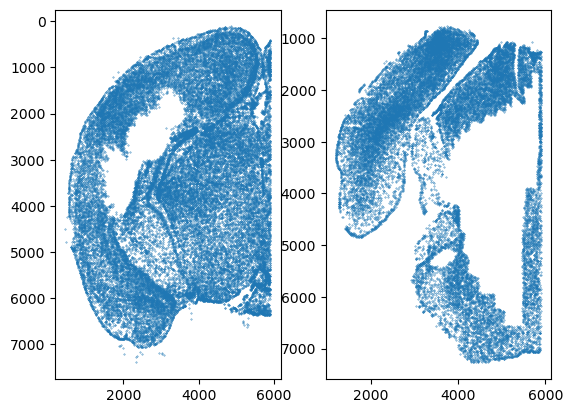

In [81]:
# identify bad slices
bad_slices = ['co2_slice94','co2_slice112']
fig, axs = plt.subplots(1,len(bad_slices))
for bad_slice, ax in zip(bad_slices, axs):
    cmd_temp = cmd[cmd.slice_id == bad_slice]
    ax.scatter(cmd_temp.ccfz, cmd_temp.ccfy, s = 0.1)
    ax.invert_yaxis()

In [82]:
# remove the bad slice
for bad_slice in bad_slices:
    cmd = cmd[cmd.slice_id != bad_slice]

In [83]:
# take only valid pixel positions in the annotated image

cmd = cmd[~cmd.ccfx.isna()]

ccfx_valid = (cmd.ccfx/ccf_pixel_size).astype(int) < annot.shape[0]
ccfy_valid = (cmd.ccfy/ccf_pixel_size).astype(int) < annot.shape[1]
ccfz_valid = (cmd.ccfz/ccf_pixel_size).astype(int) < annot.shape[2]

ccf_valid = (ccfx_valid & ccfy_valid & ccfz_valid)

cmd = cmd[ccf_valid]

In [84]:
# make annotations ints
cmd['annotation'] = cmd['annotation'].values.astype(int)

### cell type to annotations

In [29]:
# this is the dataframe that has the cell type to annotated region associations
#structure_df = pd.read_excel(r'cell_types_to_structures_v1.xlsx', header=0)

structure_df = pd.read_excel(structure_df_file, header=0)
columns_to_parse = ['cell_types','annotations']
for col in columns_to_parse:
    structure_df[col] = structure_df[col].fillna('[]')
    structure_df[col] = structure_df[col].apply(lambda x: ast.literal_eval(str(x)))

structure_df['use'] = structure_df['use'].fillna('')

structure_df['start'] = structure_df['start'].fillna(0)
structure_df['start'] = structure_df['start'].astype(int)
structure_df['stop'] = structure_df['stop'].fillna(len(annot))
structure_df['stop'] = structure_df['stop'].astype(int)

structure_df

,use,cell_types,start,stop,annotations
0,cell_types,[AD Serpinb7 Glut],0,528,[64]
1,cell_types,"[APN C1ql2 Glut, APN C1ql4 Glut]",0,528,[215]
2,cell_types,"[ARH-PVp Tbx3 Gaba, ARH-PVp Tbx3 Glut]",0,528,[223]
3,cell_types,[AV Col27a1 Glut],0,528,[255]
4,cell_types,[COAp Grxcr2 Glut],0,528,"[647, 655, 584, 376, 216, 224, 232, 663, 592, ..."
5,cell_types,[DG Glut],0,528,[632]
6,cell_types,[DMX VII Tbx20 Chol],0,528,[839]
7,cell_types,"[Ependymal NN, Tanycyte NN]",0,528,"[73, 81, 89, 98, 108, 116, 124, 129, 140, 145,..."
8,cell_types,[GPi Skor1 Gaba-Glut],0,528,[1031]
9,cell_types,[IC Tfap2d Maf Glut],0,528,"[4, 811, 820, 828]"


In [86]:
# check to make sure all cell types exists since their names were changed...

cell_types_all = cmd.subclass_label_transfer.unique()
cell_types = [item for sublist in structure_df.cell_types for item in sublist]
for c in cell_types:
    if c in cell_types_all:
        pass #print('{} exists'.format(c))
    elif c.startswith('SM_'):
        pass
    else:
        print('{} does not exist'.format(c))

In [87]:
# assign an intensity to the cell types in 16 bit space

structure_df['intensity'] = 0
factor = 500

num_regions = np.sum(structure_df.use != '')
intensities = factor * (np.arange(num_regions) + 2) # leave space for an 
# why plus 2? we don't want a zero value and we want to leave space for an 'alls cells' label

use_sequential = False
if use_sequential:
    counter = 1
    for i,row in structure_df.iterrows():
        if row.use:
            structure_df.loc[i, 'intensity'] = counter * factor
            counter += 1

use_random = True
if use_random:
    np.random.seed(12)
    np.random.shuffle(intensities)
    counter = 0
    for i,row in structure_df.iterrows():
        if row.use:
            structure_df.loc[i, 'intensity'] = intensities[counter]
            counter += 1

structure_df[structure_df.use != ''][['cell_types','intensity']].sort_values('intensity')

,cell_types,intensity
19,[NLOT Rho Glut],1000
10,[IO Fgl2 Glut],1500
32,[STN-PSTN Pitx2 Glut],2000
31,[SPVO Mafa Meis2 Glut],2500
12,[LDT Vsx2 Nkx6-1 Nfib Glut],3000
24,[PSV Pvalb Lhx2 Glut],3500
33,[VMH Nr5a1 Glut],4000
9,[IC Tfap2d Maf Glut],4500
18,[NLL Gata3 Gly-Gaba],5000
14,[ND-INC Foxd2 Glut],5500


In [88]:
intensity_unique = np.unique(structure_df.intensity)
intensity_unique[0] = factor # base value
intensity_unique = np.insert(intensity_unique, 0, 0) # do this to deal with the zero value


intensity_convert = np.zeros(intensity_unique[-1] + 1, dtype=np.uint16)
for i,val in enumerate(intensity_unique):
    intensity_convert[val] = i

intensity_revert = np.zeros(len(intensity_unique), dtype=np.uint16)
for i,val in enumerate(intensity_unique):
    intensity_revert[i] = val

### Make the 3D moving Image using Selected Annotations

In [89]:
# make the pseudo color moving image
# take only the regions of the annotation that are in the structure df

annot_select = np.zeros(annot.shape, dtype = np.uint16)

# first make a low intensity bin for all the cells
annot_select[annot > 0] = 1 * factor

# next add space modules
for i, row in structure_df.iterrows():
    if row.use == 'space_modules':
        mask = np.isin(annot, row.annotations)
        
        #start stop condition
        mask[:row.start] = False
        mask[row.stop:] = False
        annot_select[mask] = row.intensity
        

# next add cell types
for i, row in structure_df.iterrows():
    if row.use == 'cell_types':
        mask = np.isin(annot, row.annotations)
        
        # do a special case for Ependymal cells
        # this will make hollow ventricals
        if row.cell_types[0] == 'Ependymal NN':
            mask_erode = scipy.ndimage.binary_erosion(mask, iterations = 2)
            ventricle_mask = np.logical_and(mask, np.logical_not(mask_erode))   
            mask = ventricle_mask
        
        #start stop condition
        mask[:row.start] = False
        mask[row.stop:] = False
        
        annot_select[mask] = row.intensity
        
print(np.unique(annot_select))

#add a surface layer of cells to mimic the VLMC cells:
size = -1 # expand or shrink the annotation for vlmc cells?
thickness = 2 # then dilate to thickness
start_frame = 71 # dont use VLMC before this point


if size == 1:
    mask1 = annot > 0
    mask2 = scipy.ndimage.binary_dilation(mask1, iterations = thickness)
if size > 0:
    mask1 = scipy.ndimage.binary_dilation(annot > 0, iterations = size)
    mask2 = scipy.ndimage.binary_dilation(mask1, iterations = thickness)
if size < 0:
    size = np.abs(size)
    mask1 = scipy.ndimage.binary_erosion(annot > 0, iterations = size)
    mask2 = scipy.ndimage.binary_dilation(mask1, iterations = thickness)

surface = np.logical_and(mask2, np.logical_not(mask1))
surface[:start_frame] = False
    
### add the midline intersection with cortex
mask_ctx = np.isin(annot, allen_name_to_annots['Cerebral cortex'])
mask_midline = np.zeros(annot.shape, dtype = bool)
mask_midline[:,:,midline-1:midline + 2] = True
mask_midline = np.logical_and(mask_ctx, mask_midline)

surface = np.logical_or(mask_midline, surface)


# get the intensity value
for i, row in structure_df.iterrows():
    if 'VLMC NN' in row.cell_types:
        print('vlmc surface added')
        annot_select[surface] = row.intensity
        
skimage.io.imsave('selected_annotations.tif', annot_select)  

[    0   500  1000  1500  2000  2500  3000  3500  4000  4500  5000  5500
  6000  6500  7000  7500  8000  8500  9000  9500 10000 10500 11000 11500
 12000 12500 13000 13500 14000 15000 15500 16000 16500 17000 17500 18000
 18500]
vlmc surface added


### Make the 3D fixed image using cell type positions

In [90]:
arr = np.zeros(annot.shape, dtype = np.uint16)

# first add space module
for i, row in structure_df.iterrows():
    if row.use == 'space_modules':
        mask = np.zeros(annot.shape, bool)
        cmd_temp = cmd[cmd.spatial_modules_level_1_name.isin(row.cell_types)].dropna()
        i = (np.rint(cmd_temp.ccfx.values)/ccf_pixel_size).astype(int)
        j = (cmd_temp.ccfy.values/ccf_pixel_size).astype(int)
        k = (cmd_temp.ccfz.values/ccf_pixel_size).astype(int)
        mask[i,j,k] = True
        mask[:row.start] = False
        mask[row.stop:] = False
        arr[mask] = row.intensity
        
# next add cell types
for i, row in structure_df.iterrows():        
    if row.use == 'cell_types':
        mask = np.zeros(annot.shape, bool)
        cmd_temp = cmd[cmd.subclass_label_transfer.isin(row.cell_types)].dropna()
        i = (np.rint(cmd_temp.ccfx.values)/ccf_pixel_size).astype(int)
        j = (cmd_temp.ccfy.values/ccf_pixel_size).astype(int)
        k = (cmd_temp.ccfz.values/ccf_pixel_size).astype(int)
            
        # make a special case for VLMC to add surface cells
        # first make a mask
        
        if 'VLMC NN' in row.cell_types:
            dilate_1 = 1
            dilate_2 = 12
            vlmc_mask = np.logical_xor(annot > 0, scipy.ndimage.binary_dilation(annot > 0, iterations = dilate_1))
            vlmc_mask[:,:,-1] = True
            vlmc_mask = scipy.ndimage.binary_dilation(vlmc_mask, iterations = dilate_2)
            arr_vlmc_only = np.zeros(annot.shape, dtype = np.uint16)
            arr_vlmc_only[i,j,k] = row.intensity
            arr_vlmc_only = arr_vlmc_only * vlmc_mask
            arr[arr_vlmc_only > 0] = row.intensity # safer than adding...
        else:
            mask[i,j,k] = True
            mask[:row.start] = False
            mask[row.stop:] = False
            arr[mask] = row.intensity

# try a different way off expanding labels
arr2 = skimage.segmentation.expand_labels(arr, distance = 1)

# set any pixel that has a cell to a low intensity value
# but don't overwrite any of our expanded pixels
cmd_temp = cmd.dropna()
used_cell_types = list(structure_df[structure_df.use == 'cell_types'].cell_types.values)
used_cell_types = [item for sublist in used_cell_types for item in sublist]
cmd_temp = cmd_temp[~cmd_temp.subclass_label_transfer.isin(used_cell_types)]
arr_temp = np.zeros(arr.shape, dtype = bool)
i = (np.rint(cmd_temp.ccfx.values)/ccf_pixel_size).astype(int)
j = (cmd_temp.ccfy.values/ccf_pixel_size).astype(int)
k = (cmd_temp.ccfz.values/ccf_pixel_size).astype(int)
arr_temp[i,j,k] = True
arr_temp = skimage.morphology.binary_dilation(arr_temp, skimage.morphology.ball(1))

mask = np.logical_and(arr_temp, np.logical_not(arr2 > 0))

arr2[mask] = 1 * factor

In [91]:
rgb_lut = RGB_lut_255(len(np.unique(annot_select)))

skimage.io.imsave('selected_cells_RGB.tif', rgb_lut[(arr/factor).astype(np.uint8)])
skimage.io.imsave('selected_cells_dilate_RGB.tif', rgb_lut[(arr2/factor).astype(np.uint8)])
skimage.io.imsave('selected_annotations_RGB.tif', rgb_lut[(annot_select/factor).astype(np.uint8)])

In [92]:
#include the 3D nissl image as a moving image

output = np.copy(nissl)
mean_val = np.mean(output[output > 0])
factor = 2

# make a surface vlmc layer
mask = annot > 0
mask = skimage.morphology.binary_erosion(mask,skimage.morphology.ball(1))
surface = np.logical_xor(mask, skimage.morphology.binary_dilation(mask, skimage.morphology.ball(2)))    
output = output * mask # clear outside
output += surface * mean_val * factor # add vlmc layer

# Ependymal NN ventricles
annots_ENN = [81,129]
ventrical_mask = np.isin(annot, annots_ENN)
edge_mask = np.logical_xor(ventrical_mask, skimage.morphology.binary_erosion(ventrical_mask, skimage.morphology.ball(1)))

output = output * np.logical_not(ventrical_mask).astype(int) # remove ventricals
output += edge_mask * mean_val * factor # add surface

# msn
mask_mimic = (annot == 754) # bottom part of msn d1 gaba - trying to keep this from blowing out...
output[mask_mimic] = mean_val * factor

pseudo_nissl = np.copy(output).astype(np.uint16)

In [93]:
# make a 3d dapi-like image using cell positions as a fixed image

pseudo_dapi = np.zeros(annot.shape, dtype = np.uint16)

ccfx_valid = (cmd.ccfx/ccf_pixel_size).astype(int) < (annot.shape[2] - 1)
ccfy_valid = (cmd.ccfy/ccf_pixel_size).astype(int) < (annot.shape[1] - 1)
ccfz_valid = (cmd.ccfz/ccf_pixel_size).astype(int) < (annot.shape[0] - 1)

ccf_valid = (ccfx_valid & ccfy_valid & ccfz_valid)

cmd_temp = cmd[ccf_valid]

cmd_temp = cmd.dropna()
i = np.rint(cmd_temp.ccfx.values/ccf_pixel_size).astype(int)
j = (cmd_temp.ccfy.values/ccf_pixel_size).astype(int)
k = (cmd_temp.ccfz.values/ccf_pixel_size).astype(int)
pseudo_dapi[i,j,k] += 1

# enhance the cells we used above also!
enhance_cells = ['DG Glut', 'CA1-ProS Glut', 'CA3 Glut', 'VLMC NN', 'ABC NN', 'Astroependymal NN', 'Ependymal NN', 'CHOR NN']

cmd_temp = cmd[cmd.subclass_label_transfer.isin(enhance_cells)]
i = np.rint(cmd_temp.ccfx.values/ccf_pixel_size).astype(int)
j = (cmd_temp.ccfy.values/ccf_pixel_size).astype(int)
k = (cmd_temp.ccfz.values/ccf_pixel_size).astype(int)
pseudo_dapi[i,j,k] += 3

pseudo_dapi *= 5000

pseudo_dapi = skimage.filters.gaussian(pseudo_dapi, [1.5,1,1], preserve_range=True).astype(np.uint16)

# special case to mimic nissl
pseudo_dapi[mask_mimic] = np.mean(pseudo_dapi[pseudo_dapi > 0]) * 3

In [94]:
# make some spline params
num_histogram_bins = 64

p2 = sitk.GetDefaultParameterMap("bspline")
p2['NumberOfSpatialSamples'] = L2P([10000])

p2['NumberOfHistogramBins'] = L2P([num_histogram_bins])
p2['MaximumNumberOfIterations'] = L2P([2000])
p2['FinalGridSpacingInPhysicalUnits'] = L2P([])

p2['FixedImagePyramid'] = L2P(['FixedSmoothingImagePyramid','FixedSmoothingImagePyramid']) ####
p2['MovingImagePyramid'] = L2P(['MovingSmoothingImagePyramid','MovingSmoothingImagePyramid']) ####

p2['ImageSampler'] = L2P(['RandomCoordinate','RandomCoordinate'])
p2['Interpolator'] = L2P(['BSplineInterpolator','BSplineInterpolator'])

p2['NumberOfResolutions'] = L2P([3])
p2['GridSpacingSchedule'] = L2P([4,3,2])
p2['FinalGridSpacingInVoxels'] =  L2P([20,20,20])

p2['WriteResultImageAfterEachResolution'] = L2P(['true'])
p2['WriteTransformParametersEachResolution'] = L2P(['true'])

p2['NewSamplesEveryIteration'] = L2P(['true']) # useful?
p2['MaximumStepLength'] = L2P([1])

p2['Metric'] = L2P(['AdvancedMattesMutualInformation','AdvancedNormalizedCorrelation'])# ,'TransformBendingEnergyPenalty'])

p2['Metric0Weight'] = L2P([0.2])
p2['Metric1Weight'] = L2P([0.8])

p2.asdict()

{'AutomaticParameterEstimation': ('true',),
 'CheckNumberOfSamples': ('true',),
 'DefaultPixelValue': ('0.0',),
 'FinalBSplineInterpolationOrder': ('3',),
 'FinalGridSpacingInPhysicalUnits': (),
 'FinalGridSpacingInVoxels': ('20', '20', '20'),
 'FixedImagePyramid': ('FixedSmoothingImagePyramid',
  'FixedSmoothingImagePyramid'),
 'GridSpacingSchedule': ('4', '3', '2'),
 'ImageSampler': ('RandomCoordinate', 'RandomCoordinate'),
 'Interpolator': ('BSplineInterpolator', 'BSplineInterpolator'),
 'MaximumNumberOfIterations': ('2000',),
 'MaximumNumberOfSamplingAttempts': ('8',),
 'MaximumStepLength': ('1',),
 'Metric': ('AdvancedMattesMutualInformation',
  'AdvancedNormalizedCorrelation'),
 'Metric0Weight': ('0.2',),
 'Metric1Weight': ('0.8',),
 'MovingImagePyramid': ('MovingSmoothingImagePyramid',
  'MovingSmoothingImagePyramid'),
 'NewSamplesEveryIteration': ('true',),
 'NumberOfHistogramBins': ('64',),
 'NumberOfResolutions': ('3',),
 'NumberOfSamplesForExactGradient': ('4096',),
 'Number

In [95]:
# run the 3d registration

elastixImageFilter = sitk.ElastixImageFilter()

elastixImageFilter.SetParameterMap(p2)

fixed_1 = np.pad(pseudo_dapi, ((0,0),(0,0),(0,10)))
fixed_2 = np.pad(arr2, ((0,0),(0,0),(0,10)))

moving_1 = np.pad(pseudo_nissl, ((0,0),(0,0),(0,10)))
moving_2 = np.pad(annot_select, ((0,0),(0,0),(0,10)))

# clear all data before the first and after the last frame of actual data
start_frame = 23 # first frame where the data is
stop_frame = 503 # last frame where there is data
# this helps the 3d registration not get squashed

mask = np.zeros(fixed_1.shape, bool)
mask[start_frame:stop_frame] = True
mask = np.logical_not(mask)

fixed_1[mask] = 0
fixed_2[mask] = 0
moving_1[mask] = 0
moving_2[mask] = 0

elastixImageFilter.AddFixedImage(sitk.GetImageFromArray(fixed_1))
elastixImageFilter.AddFixedImage(sitk.GetImageFromArray(fixed_2))

elastixImageFilter.AddMovingImage(sitk.GetImageFromArray(moving_1))
elastixImageFilter.AddMovingImage(sitk.GetImageFromArray(moving_2))

elastixImageFilter.Execute()

result_image = sitk.GetArrayFromImage(elastixImageFilter.GetResultImage())
trans = elastixImageFilter.GetTransformParameterMap()

t = int(time.time())

skimage.io.imsave('fixed_1.tif', fixed_1)
skimage.io.imsave('fixed_2.tif', fixed_2)
skimage.io.imsave('moving_1.tif', moving_1)
skimage.io.imsave('moving_2.tif', moving_2)

C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\2305274594.py:40: UserWarning: fixed_1.tif is a low contrast image
  skimage.io.imsave('fixed_1.tif', fixed_1)


In [96]:
# use the convert revert trick to fix the interpolation issue
# save the parameter file so it can be used later

moving_spline_1 = transform_image(moving_1, trans, interpolation = False).astype(np.int16)
moving_spline_2 = intensity_revert[transform_image(intensity_convert[moving_2], trans, interpolation = False).astype(np.uint16)]

sitk.WriteParameterFile(p2, 'Params_3D_2chan_{}.txt'.format(t))
skimage.io.imsave('moving_3D_spline_chan1_{}.tif'.format(t), moving_spline_1.astype(np.uint16))
skimage.io.imsave('moving_3D_spline_chan2_{}.tif'.format(t), moving_spline_2.astype(np.uint16))

In [97]:
# transform the 25 um annotated image

annot_pad = np.pad(annot, ((0,0),(0,0),(0,10)))

spline_25 = transform_image(annot_convert[annot_pad], trans, interpolation = False)
spline_25 = annot_revert[spline_25.astype(np.uint32)]

sitk.WriteParameterFile(trans[0], 'transformation_25.txt')
skimage.io.imsave('moving_3D_spline_25_{}.tif'.format(t), spline_25)

In [34]:
# also transform the 10 um annotated image
# this will be used later when transforming back to MERFISH space

d = (np.array(moving_spline_2.shape) * 2.5).astype(int)
print(d)

annot_10, header = nrrd.read(ara_annot_10_file, index_order='F')
annot_10 = annot_10[:d[0],:d[1],:d[2]]
annot_10.shape

In [99]:
trans_10 = copy.copy(trans)

spacing = [0.4,0.4,0.4]

trans_10[0]['Size'] = L2P(np.flip(d))
trans_10[0]['Spacing'] = L2P(spacing)

spline_10 = transform_image(annot_convert[annot_10], trans_10, interpolation = False, spacing = tuple(spacing))
spline_10 = annot_revert[spline_10.astype(np.uint32)]

print(spline_10.dtype)
print(spline_10.shape)

sitk.WriteParameterFile(trans_10[0], 'transformation_10um.txt')
skimage.io.imsave('moving_3D_spline_10_{}.tif'.format(t), spline_10)

SITK spacing set to (0.4, 0.4, 0.4)
uint32
(1320, 800, 615)


### Transform the cell coordinates

In [103]:
# read in cell metadata that has ccf coordinates from reconstruction
cmd = pd.read_csv(r'wb3_co2_all_ccf2d.csv')
cmd.set_index('cell_id', inplace = True)
len(cmd)

5176286

In [104]:
for c in cmd.columns:
    print('column {} number of NAs: {}'.format(c,cmd[c].isna().sum()))

column fov number of NAs: 0
column volume number of NAs: 0
column center_x number of NAs: 0
column center_y number of NAs: 0
column sample_id number of NAs: 0
column slice_id number of NAs: 0
column fov_x number of NAs: 0
column fov_y number of NAs: 0
column integration_partition_transfer number of NAs: 373865
column integration_partition_confidence number of NAs: 373865
column subclass_label_transfer number of NAs: 373865
column subclass_label_confidence number of NAs: 373865
column cl_transfer number of NAs: 373865
column cl_confidence number of NAs: 373865
column cluster_cosine_similarity number of NAs: 373865
column adjusted_subclass_label_confidence number of NAs: 373865
column adjusted_cl_confidence number of NAs: 373865
column spatial_modules_level_1 number of NAs: 1886881
column sm1_color number of NAs: 1886881
column local_color number of NAs: 1886881
column spatial_modules_level_1_name number of NAs: 1886881
column sm1n_color number of NAs: 1886881
column lvl2_colors number o

In [105]:
for name, group in cmd.groupby('slice_id'):
    print('{}: {}'.format(name, group['ccfx'].isna().sum()))

co2_slice1: 10262
co2_slice10: 284
co2_slice100: 7707
co2_slice101: 4225
co2_slice102: 3555
co2_slice103: 2435
co2_slice104: 1684
co2_slice105: 2487
co2_slice106: 1204
co2_slice107: 1120
co2_slice108: 776
co2_slice109: 945
co2_slice11: 10117
co2_slice110: 3832
co2_slice111: 2745
co2_slice112: 2917
co2_slice113: 2359
co2_slice114: 2246
co2_slice115: 2323
co2_slice116: 2031
co2_slice117: 1142
co2_slice118: 903
co2_slice119: 2563
co2_slice12: 11850
co2_slice120: 2093
co2_slice121: 2314
co2_slice122: 2124
co2_slice123: 3897
co2_slice124: 2351
co2_slice125: 343
co2_slice126: 3312
co2_slice127: 6581
co2_slice128: 4099
co2_slice129: 4396
co2_slice13: 14737
co2_slice130: 2833
co2_slice131: 6463
co2_slice132: 2813
co2_slice133: 944
co2_slice134: 8415
co2_slice135: 6194
co2_slice136: 4550
co2_slice137: 6718
co2_slice138: 2230
co2_slice139: 3732
co2_slice14: 15770
co2_slice140: 3588
co2_slice141: 2449
co2_slice142: 27775
co2_slice143: 19722
co2_slice144: 18606
co2_slice145: 21116
co2_slice146: 20

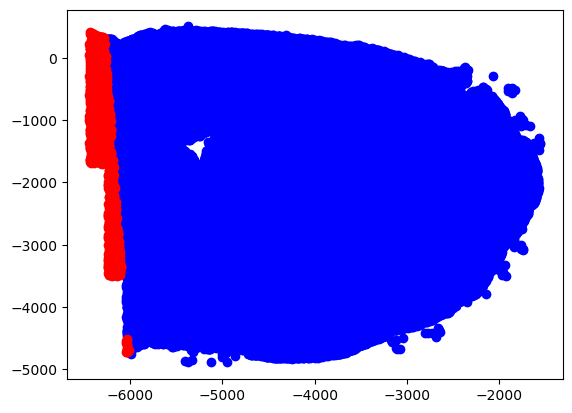

In [106]:
# show where the NAs are
slice_id = 'co2_slice60'
test_slice = cmd[cmd['slice_id'] == slice_id]
test_slice_not_NA = test_slice[~test_slice.ccfx.isna()]
test_slice_NA = test_slice[test_slice.ccfx.isna()]

plt.scatter(test_slice_not_NA.center_x, test_slice_not_NA.center_y, color = 'b')
plt.scatter(test_slice_NA.center_x, test_slice_NA.center_y, color = 'r')

In [107]:
# be careful of this drop NA step 
# it is important for transformix to not have any NA values

cmd = cmd[~cmd.annotation.isna()]
len(cmd)

4256460

In [108]:
if np.any(cmd.columns.isin(['ccfx_2', 'ccfy_2', 'ccfz_2', 'annotation_2'])):
    cmd.drop(columns=['ccfx_2', 'ccfy_2', 'ccfz_2', 'annotation_2'], inplace = True)

z = cmd.ccfx.values/ccf_pixel_size
y = cmd.ccfy.values/ccf_pixel_size
x = cmd.ccfz.values/ccf_pixel_size
cells_pos = np.array([x, y, z]).T

# write the files to the disk
write_pts_file(cells_pos)

In [109]:
# warp the points
transformixImageFilter = sitk.TransformixImageFilter()
transformixImageFilter.SetTransformParameterMap(trans)
transformixImageFilter.SetMovingImage(sitk.GetImageFromArray(moving_1))
transformixImageFilter.SetFixedPointSetFileName('points.pts')
transformixImageFilter.Execute()

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x0000012416C546F0> >

In [110]:
# read back the transformed points
output_points = read_outputpoints_file()
cells_pos_moving = output_points[:,3]

In [111]:
xloc = cells_pos_moving[:,0]
yloc = cells_pos_moving[:,1]
zloc = cells_pos_moving[:,2]

cells_pos_select = ((zloc.astype(int) < annot.shape[0] - 1) & (zloc.astype(int) >= 0) &
                    (yloc.astype(int) < annot.shape[1] - 1) & (yloc.astype(int) >= 0) &
                    (xloc.astype(int) < annot.shape[2] - 1) & (xloc.astype(int) >= 0))

xloc = xloc[cells_pos_select]
yloc = yloc[cells_pos_select]
zloc = zloc[cells_pos_select]

cells_annotations = annot[zloc.astype(int), yloc.astype(int), xloc.astype(int)]

idx = cmd.index[cells_pos_select]
cmd.loc[idx, 'ccfx_2'] = zloc * ccf_pixel_size
cmd.loc[idx, 'ccfy_2'] = yloc * ccf_pixel_size
cmd.loc[idx, 'ccfz_2'] = xloc * ccf_pixel_size
cmd.loc[:, 'annotation_2'] = np.nan # be careful here assigning NAN as default value..
cmd.loc[idx, 'annotation_2'] = cells_annotations

In [124]:
# save the 3d registration result
cmd.to_csv('wb3_co2_all_ccf3d.csv', index = True)

In [112]:
len(cmd)

4256460

### display registration results

In [113]:
# read in 10 um annotation
annot_10, header = nrrd.read(ara_annot_10_file, index_order='F')
print(annot.shape)

(528, 320, 236)


In [114]:
# this is for a curved boundary from 3D registration

def get_curved_border(cmd_subset, border_image3d, pixsize = 10, expand = 20, reflect = True):
    cmd_subset = cmd_subset.dropna()
    imdim = border_image3d[0].shape
    z_contour = np.zeros(imdim, dtype = np.uint16)
    y = (cmd_subset.ccfy_2/pixsize).astype(int)
    x = (cmd_subset.ccfz_2/pixsize).astype(int)
    z_contour[y,x] = (cmd_subset.ccfx_2/pixsize).astype(int)
    z_contour = skimage.segmentation.expand_labels(z_contour, expand)
    yy, xx = np.mgrid[0:imdim[0], 0:imdim[1]]
    output = border_image3d[z_contour, yy, xx]
    if reflect:
        center = int(imdim[1]/2)
        output[:,center:] = output[:,center:0:-1]
    return output

# this is for a 2D registration

def get_2D_border(cmd_subset, border_image3d, pixsize = 10, expand = 20, reflect = True):
    cmd_subset = cmd_subset.dropna()
    imdim = border_image3d[0].shape
    z_contour = np.zeros(imdim, dtype = np.uint16)
    y = (cmd_subset.ccfy/pixsize).astype(int)
    x = (cmd_subset.ccfz/pixsize).astype(int)
    z_contour[y,x] = (cmd_subset.ccfx/pixsize).astype(int)
    z_contour = skimage.segmentation.expand_labels(z_contour, expand)
    yy, xx = np.mgrid[0:imdim[0], 0:imdim[1]]
    output = border_image3d[z_contour, yy, xx]
    if reflect:
        center = int(imdim[1]/2)
        output[:,center:] = output[:,center:0:-1]
    return output

# add boundaries between regions
# added gaussian smoothing (set to zero for no smoothing)
def make_vector_outlines(im, smoothing = 1.5, threshhold = 0.5):
    output = []
    vals = np.unique(im)[1::] # this one drops the zero value
    for v in vals:
        mask = (im == v)
        if smoothing == 0:
            mask_contour = skimage.measure.find_contours(mask, 0.99)
        else:
            mask = skimage.filters.gaussian(mask, sigma = smoothing)
            mask_contour = skimage.measure.find_contours(mask, threshhold)
        output.append(mask_contour)
    output = [item for sublist in output for item in sublist]
    return output

In [115]:
%matplotlib inline

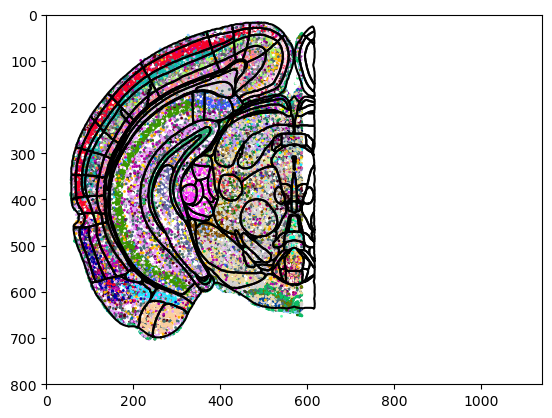

In [120]:
cmd_temp = cmd[cmd.slice_id == "co2_slice96"]

curved = get_curved_border(cmd_temp, annot_10, pixsize = 10, expand = 30, reflect = False)

outlines = make_vector_outlines(curved, smoothing = 1)

# save as svg, eps or pdf for vector
fig = plt.figure()
plt.scatter(cmd_temp.ccfz_2/10, cmd_temp.ccfy_2/10, s = 1, c = cmd_temp.lvl2_colors)    
for outline in outlines:
    plt.plot(*np.flip(outline.T), 'k')
ax = plt.gca()
ax.set_ylim(0,800)
ax.set_xlim(0,1140)
ax.invert_yaxis()
#fig.savefig('outlines_smoothed.svg')

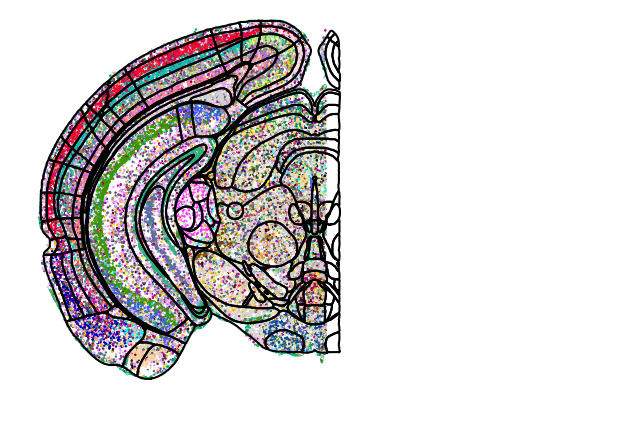

In [117]:
borders_2d = get_2D_border(cmd_temp, annot_10, pixsize = 10, expand = 30, reflect = False)
outlines = make_vector_outlines(borders_2d, smoothing = 1)

fig = plt.figure()
plt.scatter(cmd_temp.ccfz/10, cmd_temp.ccfy/10, s = .5, c = cmd_temp.lvl2_colors)
for outline in outlines:
    plt.plot(*np.flip(outline.T), 'k')
ax = plt.gca()
ax.set_ylim(0,800)
ax.set_xlim(0,1140)
ax.invert_yaxis()
ax.set_aspect('equal')
plt.axis('off')
plt.tight_layout()
#fig.savefig('test.png', transparent = True, dpi = 300)

In [121]:
# assemble and order all the slice ids
slice_ids = cmd.slice_id.unique()
slide_ids_order = np.argsort([int(sid[9:]) for sid in slice_ids])
slice_ids = slice_ids[slide_ids_order]
slice_ids

array(['co2_slice10', 'co2_slice11', 'co2_slice12', 'co2_slice13',
       'co2_slice14', 'co2_slice15', 'co2_slice16', 'co2_slice17',
       'co2_slice18', 'co2_slice19', 'co2_slice20', 'co2_slice21',
       'co2_slice22', 'co2_slice23', 'co2_slice24', 'co2_slice25',
       'co2_slice26', 'co2_slice27', 'co2_slice28', 'co2_slice29',
       'co2_slice30', 'co2_slice31', 'co2_slice32', 'co2_slice33',
       'co2_slice34', 'co2_slice35', 'co2_slice36', 'co2_slice37',
       'co2_slice38', 'co2_slice39', 'co2_slice40', 'co2_slice41',
       'co2_slice42', 'co2_slice43', 'co2_slice44', 'co2_slice45',
       'co2_slice46', 'co2_slice47', 'co2_slice48', 'co2_slice49',
       'co2_slice50', 'co2_slice51', 'co2_slice52', 'co2_slice53',
       'co2_slice54', 'co2_slice55', 'co2_slice56', 'co2_slice57',
       'co2_slice58', 'co2_slice59', 'co2_slice60', 'co2_slice61',
       'co2_slice62', 'co2_slice63', 'co2_slice64', 'co2_slice65',
       'co2_slice66', 'co2_slice67', 'co2_slice68', 'co2_slice

In [122]:
transparent = False

plt.ioff()

for sid in slice_ids:
    print('working on slice id {}'.format(sid), end = '\r')
    cmd_temp = cmd[cmd.slice_id == sid]
    curve = get_curved_border(cmd_temp, annot_10, pixsize = 10, expand = 30, reflect = False)
    outlines = make_vector_outlines(curve, smoothing = 1)
    
    fig = plt.figure(figsize = [7,10])
    plt.scatter(cmd_temp.ccfz_2/10, cmd_temp.ccfy_2/10, s = .5, c = cmd_temp.lvl2_colors)
    for outline in outlines:
        plt.plot(*np.flip(outline.T), 'k')
    ax = plt.gca()
    ax.set_ylim(0,800)
    ax.set_xlim(0,1140)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    plt.axis('off')
    plt.tight_layout()
    fig.savefig('{} 3d reg.png'.format(sid), transparent = transparent, dpi = 300)
    plt.close()
plt.ion()

In [123]:
transparent = False

plt.ioff()

for sid in slice_ids:
    print('working on slice id {}'.format(sid), end = '\r')
    cmd_temp = cmd[cmd.slice_id == sid]
    curve = get_2D_border(cmd_temp, annot_10, pixsize = 10, expand = 30, reflect = False)
    outlines = make_vector_outlines(curve, smoothing = 1)
    
    fig = plt.figure(figsize = [7,10])
    plt.scatter(cmd_temp.ccfz/10, cmd_temp.ccfy/10, s = .5, c = cmd_temp.lvl2_colors)
    for outline in outlines:
        plt.plot(*np.flip(outline.T), 'k')
    ax = plt.gca()
    ax.set_ylim(0,800)
    ax.set_xlim(0,1140)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    plt.axis('off')
    plt.tight_layout()
    fig.savefig('{} 2d reg.png'.format(sid), transparent = transparent, dpi = 300)
    plt.close()

plt.ion()
    

### Transform annotated image back to MERFISH space

In [50]:
# read in cell metadata that has ccf coordinates
cmd = pd.read_csv(r'wb3_co2_all_ccf3d.csv')
cmd.set_index('cell_id', inplace = True)

In [51]:
# this section is for transforming back to MERFISH space
# generating a warp annotation image in MERFISH space)

In [125]:
len(cmd)

4256460

In [126]:
%matplotlib qt

In [127]:
# add boundaries between regions
# added gaussian smoothing (set to zero for no smoothing)
def make_vector_outlines(im, smoothing = 1.5, threshhold = 0.5, scale = 1, border = 1):
    output = []
    
    # clear the edge 
    im[0:border] = 0
    im[-border:] = 0
    im[:,0:border] = 0
    im[:,-border:] = 0
    
    vals = np.unique(im)[1::] # this one drops the zero value
    for v in vals:
        mask = (im == v)
        if smoothing == 0:
            mask_contour = skimage.measure.find_contours(mask, 0.99)
        else:
            mask = skimage.filters.gaussian(mask, sigma = smoothing)
            mask_contour = skimage.measure.find_contours(mask, threshhold)
        output.append(mask_contour)
    output = [item * scale for sublist in output for item in sublist]
    return output

# add boundaries between regions
# added gaussian smoothing (set to zero for no smoothing)
def make_vector_outlines_dict(im, smoothing = 1.5, threshhold = 0.5, scale = 1, border = 1):
    output = {}

    # clear the edge 
    im[0:border] = 0
    im[-border:] = 0
    im[:,0:border] = 0
    im[:,-border:] = 0
    
    vals = np.unique(im)[1::] # this one drops the zero value
    for v in vals:
        mask = (im == v)
        if smoothing == 0:
            mask_contour = skimage.measure.find_contours(mask, 0.99)
        else:
            mask = skimage.filters.gaussian(mask, sigma = smoothing)
            mask_contour = skimage.measure.find_contours(mask, threshhold)
            
        if len(mask_contour) > 0:
            output[v] = [contour * scale for contour in mask_contour]
    return output

In [128]:
def convert_outlines_to_merlin(df, index, cmd, outlines_dict, ccf_pixel_size = 25, bbox = None, pad_width = 20):
    file = df.iloc[index].Filename
    rot = df.iloc[index].rot_init
    reflect = df.iloc[index].reflect
    scale_x, scale_y = [df.iloc[index].scale_x, df.iloc[index].scale_y]
    dataname, slicenum, y1, y2, x1, x2 = parse_filename(file)
    # need to know some stuff about the raw image
    imraw = skimage.io.imread(file)
    imdim = np.array(imraw.shape)
    imcenter = find_center(imraw)
    umperpixY = (y2-y1)/imdim[0]
    umperpixX = (x2-x1)/imdim[1]
    
    # here is the cell metadata subset
    cmd_temp = cmd[cmd.sample_id == df.iloc[index].cell_metadata]
    
    cells =  cmd_temp[(y1 < cmd_temp['center_y']) &
              (cmd_temp['center_y'] < y2) & 
              (x1 < cmd_temp['center_x']) & 
              (cmd_temp['center_x'] < x2)].copy() # make a copy so it does not give the slice warning...
    
    tform1 = mat_trans(-x1,-y1) # move the corner of the image to the origin
    tform2 = mat_scale(1/umperpixX, 1/umperpixY) # scale the image into pixels
    tform3 = mat_trans(imcenter[1],imcenter[0]) @ mat_rot(-rot) @ mat_trans(-imcenter[1],-imcenter[0]) # do initial rotation (translated to the center, rotate, translate back)
    shiftr, shiftc, out_rows, out_cols = find_new_corner(imdim[0], imdim[1], -rot) # find the new size of the image since it was rotated
    tform4 = mat_trans(-shiftc,-shiftr) # shift to the new corner
    tform5 = mat_reflect(reflect = reflect, dx = out_cols) # reflect if there is a reflection
    tform6 = mat_scale(scale_x,scale_y) # do final scaling in x and y which was added for better registration
    tform7 = mat_trans(-bbox[1],-bbox[0]) # crop in on the cells
    tform8 = mat_trans(pad_width,pad_width) # add padding
    tform =  tform8 @ tform7 @ tform6 @ tform5 @ tform4 @ tform3 @ tform2 @ tform1 # final transform of everything!
    
    # we will invert the transform here since we want to move back to MERLIN space
    tform = np.linalg.inv(tform)
    
    cells_pos_merlin = np.array([cells['center_x'], cells['center_y']]).T

    outlines_transformed = {}
    for key, outlines in outlines_dict.items():
        new_outlines = []
        for outline in outlines:
            new_outlines.append(transform_positions(tform, np.flip(outline, axis = 1)))
            
        outlines_transformed[key] = new_outlines

    return outlines_transformed, cells_pos_merlin, cells

In [129]:
def convert_outlines_to_fixed(df, index, cmd, outlines_dict, ccf_pixel_size = 25, bbox = None, pad_width = 20):
    file = df.iloc[index].Filename
    rot = df.iloc[index].rot_init
    reflect = df.iloc[index].reflect
    scale_x, scale_y = [df.iloc[index].scale_x, df.iloc[index].scale_y]
    dataname, slicenum, y1, y2, x1, x2 = parse_filename(file)
    # need to know some stuff about the raw image
    imraw = skimage.io.imread(file)
    imdim = np.array(imraw.shape)
    imcenter = find_center(imraw)
    umperpixY = (y2-y1)/imdim[0]
    umperpixX = (x2-x1)/imdim[1]
    
    # here is the cell metadata subset
    cmd_temp = cmd[cmd.sample_id == df.iloc[index].cell_metadata]
    
    cells =  cmd_temp[(y1 < cmd_temp['center_y']) &
                  (cmd_temp['center_y'] < y2) & 
                  (x1 < cmd_temp['center_x']) & 
                  (cmd_temp['center_x'] < x2)].copy() # make a copy so it does not give the slice warning...
    
    tform1 = mat_trans(-x1,-y1) # move the corner of the image to the origin
    tform2 = mat_scale(1/umperpixX, 1/umperpixY) # scale the image into pixels
    tform3 = mat_trans(imcenter[1],imcenter[0]) @ mat_rot(-rot) @ mat_trans(-imcenter[1],-imcenter[0]) # do initial rotation (translated to the center, rotate, translate back)
    shiftr, shiftc, out_rows, out_cols = find_new_corner(imdim[0], imdim[1], -rot) # find the new size of the image since it was rotated
    tform4 = mat_trans(-shiftc,-shiftr) # shift to the new corner
    tform5 = mat_reflect(reflect = reflect, dx = out_cols) # reflect if there is a reflection
    
    # convert to microns?
    tform_um = mat_scale(umperpixX, umperpixY) 
    
    tform =  tform_um @ tform5 @ tform4 @ tform3 @ tform2 @ tform1
    
    cells_pos = np.array([cells['center_x'], cells['center_y']]).T
    cells_pos_image_space = transform_positions(tform, cells_pos) # transform the cell positions from the initial transforms
    cells['fixed_x'] = cells_pos_image_space[:,0]
    cells['fixed_y'] = cells_pos_image_space[:,1]
    
    # transforming contours
    
    tform6 = mat_scale(scale_x,scale_y) # do final scaling in x and y which was added for better registration
    tform7 = mat_trans(-bbox[1],-bbox[0]) # crop in on the cells
    tform8 = mat_trans(pad_width,pad_width) # add padding
    tform_rev =  tform8 @ tform7 @ tform6
    
    tform_rev = tform8 @ tform7 @ tform6
    tform_rev = np.linalg.inv(tform_rev)

    # convert to microns?
    tform_rev = tform_um @ tform_rev
    
    outlines_transformed = {}
    for key, outlines in outlines_dict.items():
        new_outlines = []
        for outline in outlines:
            new_outlines.append(transform_positions(tform_rev, np.flip(outline, axis = 1)))
            
        outlines_transformed[key] = new_outlines

    return outlines_transformed, cells_pos_image_space, cells

In [130]:
cmd_temp = cmd[cmd.sample_id == df.iloc[77].cell_metadata]
cmd_temp.columns

Index(['fov', 'volume', 'center_x', 'center_y', 'sample_id', 'slice_id',
       'fov_x', 'fov_y', 'integration_partition_transfer',
       'integration_partition_confidence', 'subclass_label_transfer',
       'subclass_label_confidence', 'cl_transfer', 'cl_confidence',
       'cluster_cosine_similarity', 'adjusted_subclass_label_confidence',
       'adjusted_cl_confidence', 'spatial_modules_level_1', 'sm1_color',
       'local_color', 'spatial_modules_level_1_name', 'sm1n_color',
       'lvl2_colors', 'ccfx', 'ccfy', 'ccfz', 'annotation', 'ccfx_2', 'ccfy_2',
       'ccfz_2', 'annotation_2'],
      dtype='object')

In [131]:
# load in the high resolution annotated image
# it will have a time stamp of when it was generated
annot_3d = skimage.io.imread('moving_3D_spline_10_1690813463.tif')
annot_3d = np.rint(annot_3d).astype(np.uint32)

annot_3d = annot_3d[:,:,:-int(10 * 2.5)] # remove the pad

annot_3d.shape

(1320, 800, 590)

In [132]:
# make sure this is the same size
np.array(annot.shape) * 2.5

array([1320.,  800.,  590.])

### make an annotated image in MERFISH space

In [133]:
# make this exactly like 2D registration at the beginning of the notebook

slice_to_register = 98

print('start register slice {}'.format(slice_to_register))

num = slice_to_register - 1

df = import_df(slice_info_filename)
ccf_pixel_size = 25

filename = df.iloc[num].Filename
allen_slice_num = df.iloc[num].allen_slice_num
allen_slice_num_10 = int(allen_slice_num * 2.5)

rescale_percent = 0.99

moving_annot = annot[allen_slice_num]
moving_borders = borders[allen_slice_num]
nissl_im = nissl[allen_slice_num]

fixed = modify_dapi(df, num, cmd,
    cell_types = df.iloc[num].cell_types,
    space_modules = df.iloc[num].space_modules,
    factor = df.iloc[num].dapi_enhance_factor)

moving  = modify_nissl(nissl_im, moving_annot,
    annot_dict = df.iloc[num].annots_to_amplify,
    factor = df.iloc[num].nissl_enhance_factor)

output_10 = np.zeros((np.array(fixed.shape) * 2.5).astype(int))

# make some params
p, p2 = params_from_df(df, num)
# crop and pad images

pad_width = df.iloc[num].pad_width
print('pad width set to {}'.format(pad_width))
# probably should jsut fix the aspect ratio issue which was a legacy from similarty transform

# crop images (may not be necessary since we did it already) and add a pad
fix_bbox, fixed, _ = crop_and_pad_image(fixed, pad_width = pad_width, area_thresh = 300)
_, _, moving_borders = crop_and_pad_image(moving, moving_borders, pad_width = pad_width, area_thresh = 300) # be careful here don't overwrite the original moving...
mov_bbox, moving, moving_annot = crop_and_pad_image(moving, moving_annot, pad_width = pad_width, area_thresh = 300) 

csv_file = os.path.splitext(filename)[0] + '.csv'
if os.path.exists(csv_file):
    print('corresponding points found')
    cor_points = pd.read_csv(csv_file)
    fix_points = cor_points[['fix_x', 'fix_y']].values
    mov_points = cor_points[['mov_x', 'mov_y']].values
    
    write_pts_file(fix_points, name = 'fix.pts')
    write_pts_file(mov_points, name = 'mov.pts')


# making the high res annotated image
# here is the slice from the 3d registration
annot_3d_slice = annot_3d[allen_slice_num_10]
mov_bbox_10 = (np.array(mov_bbox) * 2.5).astype(int)
annot_3d_slice = np.pad(annot_3d_slice[mov_bbox_10[0]:mov_bbox_10[2],mov_bbox_10[1]:mov_bbox_10[3]], int(2.5*pad_width))

print('slice num {}'.format(df.iloc[num].Slice))
print('allen slice {}'.format(allen_slice_num))
print('registering in progress')

# register a slice to allen
trans, moving_spline = register_images(fixed, moving, p, p2)

# transform other images
moving_rigid = transform_image(moving, trans[0])
moving_annot_rigid = annot_revert[transform_image(annot_convert[moving_annot], trans[0], interpolation = False).astype(np.uint32)]
moving_annot_spline = annot_revert[transform_image(annot_convert[moving_annot], trans, interpolation = False).astype(np.uint32)]
moving_borders_spline = transform_image(moving_borders, trans, interpolation = True)

trans_10 = copy.copy(trans)
fixed_10_shape = (np.array(fixed.shape) * 2.5).astype(int)
for tran in trans_10:
    tran['Size'] = L2P(np.flip(fixed_10_shape))
    tran['Spacing'] = L2P([0.4,0.4])

annot_3d_slice_spline = annot_revert[transform_image(annot_convert[annot_3d_slice], trans_10, interpolation = False, spacing = (0.4,0.4)).astype(np.uint32)]
plt.figure('test')
plt.imshow(annot_3d_slice_spline, vmin = 0, vmax = 1000)


# this is the original size image?
pad = int(2.5 * pad_width)
annot_3d_slice_spline = annot_3d_slice_spline[pad:-pad,pad:-pad] # remove pad

fix_bbox_10 = (np.array(fix_bbox) * 2.5).astype(int)
w, h = annot_3d_slice_spline.shape
r = int(fix_bbox_10[0])
c = int(fix_bbox_10[1])
output_10[r:r+w,c:c+h] = annot_3d_slice_spline
annot_3d_slice_spline = output_10

# get some cell positions
if True:
    cells = get_cell_metadata_for_slice_index(df, num, cmd, ccf_pixel_size = ccf_pixel_size,
                                              bbox = fix_bbox,
                                              pad_width = pad_width)
    cells_pos_fixed = np.array([cells['fixed_x'], cells['fixed_y']]).T #- 0.5 correction to ITK?
    
    # take the slice id with the most cells (sometimes they can be mixed...)
    slice_id = cells.slice_id.value_counts().index[0]
    print(slice_id)

percent_high = 0.95

# cells converted 3d registration
fig2, axs = plt.subplots(1,2, figsize = (15,10))

#2d registration with borders
axs[0].set_title('borders')
axs[0].set_facecolor((1,1,1))
axs[0].scatter(cells['fixed_x'], cells['fixed_y'], s = 0.3, c = cells['lvl2_colors'])
axs[0].imshow(border_transparency(moving_borders_spline, RGBval = [0,0,0]))
#3d registration with vector outlines
axs[1].scatter(cells['fixed_x'], cells['fixed_y'], s = 0.3, c = cells['lvl2_colors'])


# Make the vector outlines
outlines_dict = make_vector_outlines_dict(annot_3d_slice_spline, smoothing = 1, threshhold = 0.5, scale = 0.4)

# cells and outlines in fixed space
fig4, ax = plt.subplots(1,1)
outlines_fixed_dict, cell_pos_fixed, cells = convert_outlines_to_fixed(df, num, cmd, outlines_dict,
                                                                 ccf_pixel_size = ccf_pixel_size,
                                                                 bbox = [0,0],
                                                                 pad_width = 0)
for key, outlines in outlines_fixed_dict.items():
    for outline in outlines:
        ax.plot(*outline.T, 'k')   
ax.scatter(cell_pos_fixed[:,0],cell_pos_fixed[:,1], s = 0.3, c = cells['lvl2_colors'])
ax.invert_yaxis()


# cells and tiff in fixed space
fig5, ax = plt.subplots(1,1)

sizey, sizex = annot_3d_slice_spline.shape
sizex2 = int(np.rint(sizex / df.iloc[num].scale_x))
sizey2 = int(np.rint(sizey / df.iloc[num].scale_y))

#resize back the fixed size
#the image must be float, the order must be zero and then convert back to uint32 when done
#otherwise annotations get messed up
annot_3d_slice_spline_fixed = skimage.transform.resize(annot_3d_slice_spline.astype(float), (sizey2, sizex2), order = 0, preserve_range = True)
annot_3d_slice_spline_fixed = np.rint(annot_3d_slice_spline_fixed).astype(np.uint32)
ax.scatter(cell_pos_fixed[:,0]/10,cell_pos_fixed[:,1]/10, s = 0.3, c = cells['lvl2_colors'], edgecolors = None)
ax.imshow(annot_3d_slice_spline_fixed, cmap = 'gray', vmin = 0, vmax = 1000)

# save these coordinates to the cmd dataframe
cmd.loc[cells.index, 'fixed_x'] = cell_pos_fixed[:,0]
cmd.loc[cells.index, 'fixed_y'] = cell_pos_fixed[:,1]

fig4.savefig('{}_fixed_space.png'.format(slice_id))
fig5.savefig('{}_fixed_cells.png'.format(slice_id))

skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)
    
print('done')


start register slice 98
corresponding points file found: 220714_co2_19B_merfish4_adaptor_slice1_y_0000289_005512_x_0000783_006606_25um_pix.csv
pad width set to 30
corresponding points found
slice num 98
allen slice 343
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice98
done


In [134]:
matplotlib.use('Agg')

istart = 10#10
istop = 142#142
rescale_percent = 0.99

plotQ = True

# Do a loop of a bunch of slices
slices_to_register = np.arange(istart,istop).astype(int)

for slice_to_register in slices_to_register:
    num = slice_to_register - 1
    
    print('working on slice {}/{}'.format(slice_to_register,slices_to_register[-1]))

    df = import_df(slice_info_filename)
    ccf_pixel_size = 25

    filename = df.iloc[num].Filename
    allen_slice_num = df.iloc[num].allen_slice_num
    allen_slice_num_10 = int(allen_slice_num * 2.5)

    moving_annot = annot[allen_slice_num]
    moving_borders = borders[allen_slice_num]
    nissl_im = nissl[allen_slice_num]

    fixed = modify_dapi(df, num, cmd,
        cell_types = df.iloc[num].cell_types,
        space_modules = df.iloc[num].space_modules,
        factor = df.iloc[num].dapi_enhance_factor)

    moving  = modify_nissl(nissl_im, moving_annot,
        annot_dict = df.iloc[num].annots_to_amplify,
        factor = df.iloc[num].nissl_enhance_factor)

    output_10 = np.zeros((np.array(fixed.shape) * 2.5).astype(int))

    # make some params
    p, p2 = params_from_df(df, num)
    # crop and pad images

    pad_width = df.iloc[num].pad_width
    print('pad width set to {}'.format(pad_width))
    # probably should jsut fix the aspect ratio issue which was a legacy from similarty transform

    # crop images (may not be necessary since we did it already) and add a pad
    fix_bbox, fixed, _ = crop_and_pad_image(fixed, pad_width = pad_width, area_thresh = 300)
    _, _, moving_borders = crop_and_pad_image(moving, moving_borders, pad_width = pad_width, area_thresh = 300) # be careful here don't overwrite the original moving...
    mov_bbox, moving, moving_annot = crop_and_pad_image(moving, moving_annot, pad_width = pad_width, area_thresh = 300) 

    csv_file = os.path.splitext(filename)[0] + '.csv'
    if os.path.exists(csv_file):
        print('corresponding points found')
        cor_points = pd.read_csv(csv_file)
        fix_points = cor_points[['fix_x', 'fix_y']].values
        mov_points = cor_points[['mov_x', 'mov_y']].values

        write_pts_file(fix_points, name = 'fix.pts')
        write_pts_file(mov_points, name = 'mov.pts')
    
    # making the high res annotated image
    # here is the slice from the 3d registration
    annot_3d_slice = annot_3d[allen_slice_num_10]
    mov_bbox_10 = (np.array(mov_bbox) * 2.5).astype(int)
    annot_3d_slice = np.pad(annot_3d_slice[mov_bbox_10[0]:mov_bbox_10[2],mov_bbox_10[1]:mov_bbox_10[3]], int(2.5*pad_width))

    print('slice num {}'.format(df.iloc[num].Slice))
    print('allen slice {}'.format(allen_slice_num))
    print('registering in progress')

    # register a slice to allen
    trans, moving_spline = register_images(fixed, moving, p, p2)

    # transform other images
    moving_rigid = transform_image(moving, trans[0])
    moving_annot_rigid = annot_revert[transform_image(annot_convert[moving_annot], trans[0], interpolation = False).astype(np.uint32)]
    moving_annot_spline = annot_revert[transform_image(annot_convert[moving_annot], trans, interpolation = False).astype(np.uint32)]
    moving_borders_spline = transform_image(moving_borders, trans, interpolation = True)

    trans_10 = copy.copy(trans)
    fixed_10_shape = (np.array(fixed.shape) * 2.5).astype(int)
    for tran in trans_10:
        tran['Size'] = L2P(np.flip(fixed_10_shape))
        tran['Spacing'] = L2P([0.4,0.4])

    annot_3d_slice_spline = annot_revert[transform_image(annot_convert[annot_3d_slice], trans_10, interpolation = False, spacing = (0.4,0.4)).astype(np.uint32)]
    plt.figure('test')
    plt.imshow(annot_3d_slice_spline, vmin = 0, vmax = 1000)

    # this is the original size image?
    pad = int(2.5 * pad_width)
    annot_3d_slice_spline = annot_3d_slice_spline[pad:-pad,pad:-pad] # remove pad

    fix_bbox_10 = (np.array(fix_bbox) * 2.5).astype(int)
    w, h = annot_3d_slice_spline.shape
    r = int(fix_bbox_10[0])
    c = int(fix_bbox_10[1])
    output_10[r:r+w,c:c+h] = annot_3d_slice_spline
    annot_3d_slice_spline = output_10

    # get some cell positions
    if True:
        cells = get_cell_metadata_for_slice_index(df, num, cmd, ccf_pixel_size = ccf_pixel_size,
                                                  bbox = fix_bbox,
                                                  pad_width = pad_width)
        cells_pos_fixed = np.array([cells['fixed_x'], cells['fixed_y']]).T #- 0.5 correction to ITK?

        # take the slice id with the most cells (sometimes they can be mixed...)
        slice_id = cells.slice_id.value_counts().index[0]
        print(slice_id)

    percent_high = 0.95

    # cells converted 3d registration
    fig2, axs = plt.subplots(1,2, figsize = (15,10))

    #2d registration with borders
    axs[0].set_title('borders')
    axs[0].set_facecolor((1,1,1))
    axs[0].scatter(cells['fixed_x'], cells['fixed_y'], s = 0.3, c = cells['lvl2_colors'])
    axs[0].imshow(border_transparency(moving_borders_spline, RGBval = [0,0,0]))
    #3d registration with vector outlines
    axs[1].scatter(cells['fixed_x'], cells['fixed_y'], s = 0.3, c = cells['lvl2_colors'])


    # Make the vector outlines
    outlines_dict = make_vector_outlines_dict(annot_3d_slice_spline, smoothing = 1, threshhold = 0.5, scale = 0.4)

    # cells and outlines in fixed space
    fig4, ax = plt.subplots(1,1)
    outlines_fixed_dict, cell_pos_fixed, cells = convert_outlines_to_fixed(df, num, cmd, outlines_dict,
                                                                     ccf_pixel_size = ccf_pixel_size,
                                                                     bbox = [0,0],
                                                                     pad_width = 0)
    for key, outlines in outlines_fixed_dict.items():
        for outline in outlines:
            ax.plot(*outline.T, 'k')   
    ax.scatter(cell_pos_fixed[:,0],cell_pos_fixed[:,1], s = 0.3, c = cells['lvl2_colors'])
    ax.invert_yaxis()

    # cells and tiff in fixed space
    fig5, ax = plt.subplots(1,1)

    sizey, sizex = annot_3d_slice_spline.shape
    sizex2 = int(np.rint(sizex / df.iloc[num].scale_x))
    sizey2 = int(np.rint(sizey / df.iloc[num].scale_y))

    #resize back the fixed size
    #the image must be float, the order must be zero and then convert back to uint32 when done
    #otherwise annotations get messed up
    annot_3d_slice_spline_fixed = skimage.transform.resize(annot_3d_slice_spline.astype(float), (sizey2, sizex2), order = 0, preserve_range = True)
    annot_3d_slice_spline_fixed = np.rint(annot_3d_slice_spline_fixed).astype(np.uint32)
    ax.scatter(cell_pos_fixed[:,0]/10,cell_pos_fixed[:,1]/10, s = 0.3, c = cells['lvl2_colors'], edgecolors = None)
    ax.imshow(annot_3d_slice_spline_fixed, cmap = 'gray', vmin = 0, vmax = 1000)

    # save these coordinates to the cmd dataframe
    cmd.loc[cells.index, 'fixed_x'] = cell_pos_fixed[:,0]
    cmd.loc[cells.index, 'fixed_y'] = cell_pos_fixed[:,1]

    fig4.savefig('{}_fixed_space.png'.format(slice_id))
    fig5.savefig('{}_fixed_cells.png'.format(slice_id))

    skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)

    plt.close('all')

working on slice 10/141
pad width set to 20
slice num 10
allen slice 22
registering in progress
SITK spacing set to (0.4, 0.4)
co2_slice10


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice10_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 11/141
pad width set to 20
slice num 11
allen slice 25
registering in progress
SITK spacing set to (0.4, 0.4)
co2_slice11


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice11_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 12/141
pad width set to 20
slice num 12
allen slice 28
registering in progress
SITK spacing set to (0.4, 0.4)
co2_slice12


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice12_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 13/141
corresponding points file found: 220601_wb3_co2_2_5z18R2bd_merfish6_slice1_y_0003209_006232_x_0005113_009337_25um_pix.csv
pad width set to 20
corresponding points found
slice num 13
allen slice 31
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice13


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice13_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 14/141
corresponding points file found: 220726_wb3_co2_B_2_5z18R_merfish5_slice1_y_-006126_-02703_x_-008749_-04326_25um_pix.csv
pad width set to 20
corresponding points found
slice num 14
allen slice 34
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice14


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice14_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 15/141
corresponding points file found: 220604_wb3_co2_3_5z18R2bd_merfish5_slice2_y_-006084_-03061_x_-005210_-00587_25um_pix.csv
pad width set to 20
corresponding points found
slice num 15
allen slice 37
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice15


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice15_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 16/141
corresponding points file found: 220722_wb3_co2_B_3_5z18R_merfish5_slice2_y_-004962_-01539_x_-010384_-05761_25um_pix.csv
pad width set to 20
corresponding points found
slice num 16
allen slice 40
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice16


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice16_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 17/141
corresponding points file found: 220530_wb3_co2_4_5z18R_merfish5_slice2_y_-006320_-03497_x_-009745_-05322_25um_pix.csv
pad width set to 20
corresponding points found
slice num 17
allen slice 43
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice17


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice17_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 18/141
corresponding points file found: 220623_co2_4B_merfish4_adaptor_slice1_y_-003625_-01002_x_-005325_-02302_25um_pix.csv
pad width set to 20
corresponding points found
slice num 18
allen slice 46
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice18


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice18_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 19/141
pad width set to 20
slice num 19
allen slice 49
registering in progress
SITK spacing set to (0.4, 0.4)
co2_slice19


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice19_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 20/141
pad width set to 20
slice num 20
allen slice 52
registering in progress
SITK spacing set to (0.4, 0.4)
co2_slice20


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice20_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 21/141
corresponding points file found: 220601_wb3_co2_1_5z18R2bd_merfish5_slice2_y_-002327_000695_x_-007211_-02988_25um_pix.csv
pad width set to 20
corresponding points found
slice num 21
allen slice 55
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice21


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice21_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 22/141
corresponding points file found: 220726_co2_1B_merfish4_adaptor_slice2_y_-000500_003722_x_-001491_001532_25um_pix.csv
pad width set to 20
corresponding points found
slice num 22
allen slice 58
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice22


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice22_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 23/141
corresponding points file found: 220601_wb3_co2_2_5z18R2bd_merfish6_slice2_y_-000907_001715_x_0003231_007454_25um_pix.csv
pad width set to 20
corresponding points found
slice num 23
allen slice 62
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice23


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice23_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 24/141
corresponding points file found: 220726_wb3_co2_B_2_5z18R_merfish5_slice2_y_-001326_001696_x_-007002_-02779_25um_pix.csv
pad width set to 20
corresponding points found
slice num 24
allen slice 70
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice24


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice24_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 25/141
corresponding points file found: 220604_wb3_co2_3_5z18R2bd_merfish5_slice1_y_-001208_002215_x_-002714_001508_25um_pix.csv
pad width set to 20
corresponding points found
slice num 25
allen slice 78
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice25


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice25_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 26/141
corresponding points file found: 220722_wb3_co2_B_3_5z18R_merfish5_slice1_y_0000260_003883_x_-008267_-04044_25um_pix.csv
pad width set to 20
corresponding points found
slice num 26
allen slice 80
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice26


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice26_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 27/141
pad width set to 20
slice num 27
allen slice 82
registering in progress
SITK spacing set to (0.4, 0.4)
co2_slice27


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice27_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 28/141
corresponding points file found: 220623_co2_4B_merfish4_adaptor_slice2_y_0000691_004514_x_-005126_-00103_25um_pix.csv
pad width set to 30
corresponding points found
slice num 28
allen slice 84
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice28


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice28_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 29/141
corresponding points file found: 220530_wb3_co2_5_5z18R_merfish6_slice1_y_-000936_002886_x_-003657_001365_25um_pix.csv
pad width set to 20
corresponding points found
slice num 29
allen slice 86
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice29
working on slice 30/141
pad width set to 20
slice num 30
allen slice 88
registering in progress
SITK spacing set to (0.4, 0.4)
co2_slice30
working on slice 31/141
pad width set to 20
slice num 31
allen slice 91
registering in progress
SITK spacing set to (0.4, 0.4)
co2_slice31
working on slice 32/141
corresponding points file found: 220726_co2_1B_merfish4_adaptor_slice1_y_-003754_-00531_x_0001787_005811_25um_pix.csv
pad width set to 20
corresponding points found
slice num 32
allen slice 94
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice32
working on slice 33/141
pad width set to 20
slice num 33
allen slice 98
registering in progress
SITK 

C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice35_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 36/141
pad width set to 20
slice num 36
allen slice 110
registering in progress
SITK spacing set to (0.4, 0.4)
co2_slice36


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice36_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 37/141
pad width set to 20
slice num 37
allen slice 114
registering in progress
SITK spacing set to (0.4, 0.4)
co2_slice37


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice37_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 38/141
pad width set to 20
slice num 38
allen slice 118
registering in progress
SITK spacing set to (0.4, 0.4)
co2_slice38


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice38_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 39/141
pad width set to 20
slice num 39
allen slice 122
registering in progress
SITK spacing set to (0.4, 0.4)
co2_slice39


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice39_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 40/141
pad width set to 20
slice num 40
allen slice 127
registering in progress
SITK spacing set to (0.4, 0.4)
co2_slice40


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice40_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 41/141
corresponding points file found: 220511_co2_6_merfish4_adaptor_slice0_y_-004717_-00493_x_0000551_005175_25um_pix.csv
pad width set to 20
corresponding points found
slice num 41
allen slice 131
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice41


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice41_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 42/141
corresponding points file found: 220723_co2_6B_merfish4_adaptor_slice2_y_0001783_006406_x_0000170_004193_25um_pix.csv
pad width set to 20
corresponding points found
slice num 42
allen slice 135
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice42


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice42_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 43/141
corresponding points file found: 220516_wb3_co2_7_5z18R_merfish5_slice2_y_0005349_010573_x_0002830_007453_25um_pix.csv
pad width set to 20
corresponding points found
slice num 43
allen slice 140
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice43


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice43_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 44/141
corresponding points file found: 220711_co2_7B_merfish4_adaptor_slice2_y_0000610_005033_x_-006793_-01769_25um_pix.csv
pad width set to 20
corresponding points found
slice num 44
allen slice 143
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice44


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice44_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 45/141
corresponding points file found: 220516_wb3_co2_8_5z18R_merfish6_slice2_y_-009031_-04208_x_-006310_-01687_25um_pix.csv
pad width set to 20
corresponding points found
slice num 45
allen slice 147
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice45


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice45_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 46/141
corresponding points file found: 220616_co2_8B_merfish4_adaptor_slice2_y_0000238_004661_x_-006426_-01403_25um_pix.csv
pad width set to 20
corresponding points found
slice num 46
allen slice 151
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice46


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice46_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 47/141
corresponding points file found: 220720_co2_9_merfish4_adaptor_slice2_y_-006508_-01485_x_-005551_-01128_25um_pix.csv
pad width set to 20
corresponding points found
slice num 47
allen slice 155
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice47


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice47_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 48/141
corresponding points file found: 220513_wb3_co2_9_5z18R_merfish5_slice2_y_-006568_-01545_x_-007224_-02801_25um_pix.csv
pad width set to 20
corresponding points found
slice num 48
allen slice 159
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice48


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice48_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 49/141
corresponding points file found: 220506_wb3_co2_10_5z18R_merfish2_slice2_y_-002924_001699_x_-004116_001106_25um_pix.csv
pad width set to 20
corresponding points found
slice num 49
allen slice 163
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice49


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice49_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 50/141
corresponding points file found: 220703_co2_10B_merfish4_adaptor_slice1_y_-004607_000015_x_0000740_006164_25um_pix.csv
pad width set to 20
corresponding points found
slice num 50
allen slice 167
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice50


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice50_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 51/141
corresponding points file found: 220511_co2_6_merfish4_adaptor_slice2_y_0001595_006618_x_0000478_005702_25um_pix.csv
pad width set to 20
corresponding points found
slice num 51
allen slice 171
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice51


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice51_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 52/141
pad width set to 20
slice num 52
allen slice 175
registering in progress
SITK spacing set to (0.4, 0.4)
co2_slice52


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice52_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 53/141
pad width set to 20
slice num 53
allen slice 179
registering in progress
SITK spacing set to (0.4, 0.4)
co2_slice53


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice53_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 54/141
corresponding points file found: 220711_co2_7B_merfish4_adaptor_slice0_y_0000615_005239_x_0000204_004827_25um_pix.csv
pad width set to 20
corresponding points found
slice num 54
allen slice 183
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice54
working on slice 55/141
corresponding points file found: 220516_wb3_co2_8_5z18R_merfish6_slice1_y_-002006_003416_x_-008690_-03466_25um_pix.csv
pad width set to 20
corresponding points found
slice num 55
allen slice 187
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice55
working on slice 56/141
corresponding points file found: 220616_co2_8B_merfish4_adaptor_slice1_y_0001584_006007_x_0001455_006278_25um_pix.csv
pad width set to 20
corresponding points found
slice num 56
allen slice 191
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice56
working on slice 57/141
corresponding points file found: 220720_co

SITK spacing set to (0.4, 0.4)
co2_slice80
working on slice 81/141
corresponding points file found: 220605_co2_11B_merfish4_adaptor_slice0_y_0001515_007339_x_-003461_002762_25um_pix.csv
pad width set to 50
corresponding points found
slice num 81
allen slice 273
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice81
working on slice 82/141
corresponding points file found: 220507_wb3_co2_11_5z18R_merfish5_slice1_y_-004359_001664_x_0004255_009878_25um_pix.csv
pad width set to 20
corresponding points found
slice num 82
allen slice 278
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice82
working on slice 83/141
corresponding points file found: 220606_wb3_co2_12_5z18R2bd_merfish5_slice0_y_-002569_003453_x_-007906_-02083_25um_pix.csv
pad width set to 20
corresponding points found
slice num 83
allen slice 283
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice83
working on slice

SITK spacing set to (0.4, 0.4)
co2_slice108
working on slice 109/141
corresponding points file found: 220523_wb3_co2_20_5z18R2bd_merfish5_slice2_y_-001745_002677_x_-003576_001646_25um_pix.csv
pad width set to 20
corresponding points found
slice num 109
allen slice 383
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice109
working on slice 110/141
corresponding points file found: 220630_wb3_co2_20_5z18R_merfish6_slice0_y_-002396_002826_x_-001404_004018_25um_pix.csv
pad width set to 20
corresponding points found
slice num 110
allen slice 387
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice110
working on slice 111/141
pad width set to 20
slice num 111
allen slice 392
registering in progress
SITK spacing set to (0.4, 0.4)
co2_slice111
working on slice 112/141
pad width set to 20
slice num 112
allen slice 396
registering in progress
SITK spacing set to (0.4, 0.4)
co2_slice112
working on slice 113/141
correspond

C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice115_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 116/141
corresponding points file found: 220620_wb3_co2_B_18_5z18R_merfish5_slice0_y_-007351_-02127_x_-000413_004409_25um_pix.csv
pad width set to 50
corresponding points found
slice num 116
allen slice 413
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice116


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice116_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 117/141
corresponding points file found: 220517_co2_19_merfish4_adaptor_slice0_y_-001124_003298_x_-007301_-02078_25um_pix.csv
pad width set to 30
corresponding points found
slice num 117
allen slice 416
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice117


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice117_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 118/141
corresponding points file found: 220714_co2_19B_merfish4_adaptor_slice0_y_-005310_-00287_x_-005239_-00016_25um_pix.csv
pad width set to 20
corresponding points found
slice num 118
allen slice 419
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice118


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice118_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 119/141
corresponding points file found: 220523_wb3_co2_20_5z18R2bd_merfish5_slice0_y_-008585_-03762_x_-004454_000768_25um_pix.csv
pad width set to 20
corresponding points found
slice num 119
allen slice 422
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice119


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice119_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 120/141
corresponding points file found: 220630_wb3_co2_20_5z18R_merfish6_slice1_y_0004449_009073_x_-004341_001082_25um_pix.csv
pad width set to 20
corresponding points found
slice num 120
allen slice 425
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice120


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice120_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 121/141
corresponding points file found: 220525_wb3_co2_21_5z18R2bd_merfish6_slice2_y_-003215_002007_x_-002043_002580_25um_pix.csv
pad width set to 20
corresponding points found
slice num 121
allen slice 428
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice121


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice121_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 122/141
corresponding points file found: 220623_wb3_co2_21_5z18R_merfish5_slice2_y_0003812_009035_x_-001042_003780_25um_pix.csv
pad width set to 20
corresponding points found
slice num 122
allen slice 431
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice122


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice122_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 123/141
corresponding points file found: 220525_wb3_co2_22_5z18R2bd_merfish5_slice0_y_-005057_000765_x_0005607_011030_25um_pix.csv
pad width set to 20
corresponding points found
slice num 123
allen slice 434
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice123


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice123_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 124/141
corresponding points file found: 220620_wb3_co2_B_22_5z18R_merfish6_slice0_y_-003306_001516_x_0003714_008937_25um_pix.csv
pad width set to 20
corresponding points found
slice num 124
allen slice 437
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice124


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice124_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 125/141
corresponding points file found: 220523_co2_23_merfish4_adaptor_slice2_y_-004532_000290_x_-000059_005164_25um_pix.csv
pad width set to 20
corresponding points found
slice num 125
allen slice 440
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice125


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice125_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 126/141
corresponding points file found: 220719_wb3_co2_B_23_5z18R_merfish5_slice2_y_-002292_003130_x_-007091_-01268_25um_pix.csv
pad width set to 20
corresponding points found
slice num 126
allen slice 444
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice126


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice126_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 127/141
corresponding points file found: 220528_wb3_co2_24_5z18R2bd_merfish6_slice1_y_-002575_002847_x_-002543_003079_25um_pix.csv
pad width set to 20
corresponding points found
slice num 127
allen slice 448
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice127


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice127_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 128/141
corresponding points file found: 220623_wb3_co2_24_5z18R_merfish6_slice1_y_-007648_-01425_x_0003417_009440_25um_pix.csv
pad width set to 20
corresponding points found
slice num 128
allen slice 452
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice128


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice128_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 129/141
corresponding points file found: 220525_wb3_co2_21_5z18R2bd_merfish6_slice1_y_-003933_001289_x_0004770_009793_25um_pix.csv
pad width set to 20
corresponding points found
slice num 129
allen slice 456
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice129


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice129_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 130/141
corresponding points file found: 220623_wb3_co2_21_5z18R_merfish5_slice1_y_-001921_003101_x_-002878_001944_25um_pix.csv
pad width set to 20
corresponding points found
slice num 130
allen slice 460
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice130


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice130_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 131/141
corresponding points file found: 220525_wb3_co2_22_5z18R2bd_merfish5_slice2_y_0002040_007263_x_0006063_011086_25um_pix.csv
pad width set to 20
corresponding points found
slice num 131
allen slice 464
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice131


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice131_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 132/141
corresponding points file found: 220620_wb3_co2_B_22_5z18R_merfish6_slice1_y_-001184_004038_x_-002174_002849_25um_pix.csv
pad width set to 20
corresponding points found
slice num 132
allen slice 468
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice132


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice132_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 133/141
corresponding points file found: 220523_co2_23_merfish4_adaptor_slice1_y_0001602_006225_x_0000020_005443_25um_pix.csv
pad width set to 20
corresponding points found
slice num 133
allen slice 472
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice133


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice133_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 134/141
corresponding points file found: 220719_wb3_co2_B_23_5z18R_merfish5_slice1_y_-006459_-00635_x_-000849_005173_25um_pix.csv
pad width set to 20
corresponding points found
slice num 134
allen slice 477
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice134


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice134_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 135/141
corresponding points file found: 220528_wb3_co2_24_5z18R2bd_merfish6_slice2_y_-002277_003345_x_-009201_-03978_25um_pix.csv
pad width set to 20
corresponding points found
slice num 135
allen slice 482
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice135


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice135_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 136/141
corresponding points file found: 220623_wb3_co2_24_5z18R_merfish6_slice2_y_-001142_004680_x_-002004_003618_25um_pix.csv
pad width set to 20
corresponding points found
slice num 136
allen slice 484
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice136


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice136_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 137/141
pad width set to 20
slice num 137
allen slice 487
registering in progress
SITK spacing set to (0.4, 0.4)
co2_slice137


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice137_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 138/141
pad width set to 20
slice num 138
allen slice 490
registering in progress
SITK spacing set to (0.4, 0.4)
co2_slice138


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice138_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 139/141
corresponding points file found: 220525_wb3_co2_22_5z18R2bd_merfish5_slice1_y_-000985_004637_x_-002078_002544_25um_pix.csv
pad width set to 20
corresponding points found
slice num 139
allen slice 493
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice139


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice139_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 140/141
corresponding points file found: 220620_wb3_co2_B_22_5z18R_merfish6_slice2_y_-010056_-04633_x_-002189_003033_25um_pix.csv
pad width set to 30
corresponding points found
slice num 140
allen slice 496
registering in progress
load corresponding points
SITK spacing set to (0.4, 0.4)
co2_slice140


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice140_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 141/141
pad width set to 20
slice num 141
allen slice 502
registering in progress
SITK spacing set to (0.4, 0.4)
co2_slice141


C:\Users\aaron\AppData\Local\Temp\ipykernel_28904\4260475119.py:164: UserWarning: co2_slice141_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


In [135]:
len(cmd)

4256460

In [136]:
# save fixed_x and fixed_y to dataframe
cmd.to_csv('wb3_co2_all_ccf3d.csv', index = True, index_label = 'cell_id')